# **Understanding Machine Learning Models - Clustering segment**

Supervisor: Dr. Kovács Edith Alice \\
The paper that served as the main motivation: https://arxiv.org/pdf/2103.05678.pdf

## Installing and importing the needed libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install umap-learn
!pip install shap
!pip install pybind11

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 6.0 MB/s 
     |████████████████████████████████| 1.1 MB 36.5 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=c9ed5bfc67b1fda61ce764a7dddaaa3a7351c188ac0ba903a72fdaa45ea8d758
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=f74f7e78e4eb5b623c18bd429e8aa9df88260b2b000b4ab9f1de0c15bcc67347
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 22.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-

In [ ]:
!pip install cluster-shapley

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from numpy.linalg import svd

from matplotlib import pyplot as plt
import umap.umap_ as umap
import random

import dr_explainer as dre
import shap

from sklearn.decomposition import PCA
from IPython.display import Image

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering 

import warnings
warnings.filterwarnings('ignore')

## Loading and preprocessing the data

The data source is the database of István Szakadát, administrator of the page: o-o-o.hu. The data consists of the statistics of 3000 Hungarian settlements from 1990 up until 2018. I used only the numbers from 2010 as it has least missing elements. Also normalized the data with the population number to avoid inequalities resulting from different settlement sizes.

In [ ]:
geoname = pd.read_csv('/content/drive/My Drive/tstar/geoname.csv')
geoname['name'] = geoname['name'].astype("string")

dt_colnames_full = ['datatypeid','kshkod' ,'label','measureunit','periodicity','note_hun','referencetime','validity','reference','source','leafornot','parentid','label_hun2007','mtaktid','admin_hun','max','min','avg','conceptid']
dt_colnames_useful = ['datatypeid','kshkod' ,'label']
datatype = pd.read_csv('/content/drive/My Drive/tstar/datatype.csv', names=dt_colnames_full, usecols=dt_colnames_useful)
datatype['kshkod'] = datatype['kshkod'].astype("string")
datatype['label'] = datatype['label'].astype("string")
datatype['kshkod'] = datatype['kshkod'].str.strip()

export_colnames = ['year','value','geonameid','datatypeid']
export = pd.read_csv('/content/drive/My Drive/tstar/export.csv', names=export_colnames) 
export = export.dropna()
export = export.astype({'geonameid': 'int'})

lakossagi_dim = ['TAAA101','TAAQ002','TAAR001','TAAR128','TAAR023','TAAS001','TAAH003','TAAH000','TAAH201','TAAH305','TAAJ425']
datatype_lak = datatype[datatype['kshkod'].isin(lakossagi_dim)]
merge_temp = geoname.merge(export, on='geonameid')
data_lak = merge_temp.merge(datatype_lak, on='datatypeid')

In [ ]:
year=2010

pd.options.mode.chained_assignment = None  # default='warn'
data_lak_clus = data_lak[data_lak.year==year]

data_lak_clus['ind']=list(map(lambda x,y,z,w: (x,y,z,w), data_lak_clus['name'],data_lak_clus['geoid'],data_lak_clus['wgs84_e_szelesseg'],data_lak_clus['wgs84_k_hosszusag'] ))
data_lak_clus = data_lak_clus[['ind', 'value', 'label']]
data_lak_clus = pd.crosstab(data_lak_clus.ind, data_lak_clus.label, values=data_lak_clus.value, aggfunc=lambda x: x)

for i in range(len(data_lak_clus)):
  data_lak_clus.iloc[i]=data_lak_clus.iloc[i]/data_lak_clus.iloc[i]['lakónépesség száma az év végén']

data_lak_clus=data_lak_clus.drop(['lakónépesség száma az év végén'], axis=1)
data_lak_clus=data_lak_clus.fillna(0)

In [ ]:
data_lak_clus.head()

label                                               a háztartások részére szolgáltatott villamosenergia mennyisége  \
ind                                                                                                                  
(Aba, 1512, 47.0343556977497, 18.524754962635)                                               0.926401                
(Abaliget, 1035, 46.1438461930372, 18.118110841...                                           1.316781                
(Abasár, 2209, 47.8006871447644, 20.0083983387857)                                           1.375349                
(Abaújalpár, 1341, 48.3061466428872, 21.2340965...                                           0.760000                
(Abaújkér, 2420, 48.3050378371762, 21.200220781...                                           0.862267                

label                                               az összes szolgáltatott gáz mennyiségéből a háztartások részére szolgáltatott gáz mennyisége (átszámítás nélkül)  \
ind                                                                                                                                                                    
(Aba, 1512, 47.0343556977497, 18.524754962635)                                               0.360291                                                                  
(Abaliget, 1035, 46.1438461930372, 18.118110841...                                           0.000000                                                                  
(Abasár, 2209, 47.8006871447644, 20.0083983387857)                                           0.415636                                                                  
(Abaújalpár, 1341, 48.3061466428872, 21.2340965...                                           0.186667                                                                  
(Abaújkér, 2420, 48.3050378371762, 21.200220781...                                           0.199426                                                                  

label                                               háztartásoknak szolgáltatott víz mennyisége  \
ind                                                                                               
(Aba, 1512, 47.0343556977497, 18.524754962635)                                         0.026744   
(Abaliget, 1035, 46.1438461930372, 18.118110841...                                     0.034247   
(Abasár, 2209, 47.8006871447644, 20.0083983387857)                                     0.032708   
(Abaújalpár, 1341, 48.3061466428872, 21.2340965...                                     0.013333   
(Abaújkér, 2420, 48.3050378371762, 21.200220781...                                     0.018651   

label                                               regisztrált munkanélküliek száma összesen  \
ind                                                                                             
(Aba, 1512, 47.0343556977497, 18.524754962635)                                       0.056055   
(Abaliget, 1035, 46.1438461930372, 18.118110841...                                   0.099315   
(Abasár, 2209, 47.8006871447644, 20.0083983387857)                                   0.060630   
(Abaújalpár, 1341, 48.3061466428872, 21.2340965...                                   0.253333   
(Abaújkér, 2420, 48.3050378371762, 21.200220781...                                   0.114778   

label                                               személygépkocsik száma  \
ind                                                                          
(Aba, 1512, 47.0343556977497, 18.524754962635)                    0.226786   
(Abaliget, 1035, 46.1438461930372, 18.118110841...                0.330479   
(Abasár, 2209, 47.8006871447644, 20.0083983387857)                0.378141   
(Abaújalpár, 1341, 48.3061466428872, 21.2340965...                0.280000   
(Abaújkér, 2420, 48.3050378371762, 21.200220781...                0.164993   

label                                               szociális étkeztetésben

## Analysis of residential data

First of all defined a list of variables which describe well the financial power of the residents in each settlement.

In [ ]:
lak_vars = ['TAAA101', 'TAAB101','TAAQ002','TAAR001','TAAR128', 'TAAR012', 'TAAS001', 'TAAS019', 'TAAS020','TAAS036','TAAT126','TAAT127','TAAH003','TAAH000','TAAH200','TAAH201','TAAH300','TAAH305','TAAJ425']
# 18 darab változó + lakosságszám

In [ ]:
datatype_lak_full = datatype[datatype['kshkod'].isin(lak_vars)]
data_lak_full = merge_temp.merge(datatype_lak_full, on='datatypeid')

In [ ]:
year=2010

pd.options.mode.chained_assignment = None  # default='warn'
data_lak_clus_full = data_lak_full[data_lak_full.year==year]

data_lak_clus_full['ind']=list(map(lambda x,y,z,w: (x,y,z,w), data_lak_clus_full['name'],data_lak_clus_full['geoid'],data_lak_clus_full['wgs84_e_szelesseg'],data_lak_clus_full['wgs84_k_hosszusag'] ))
data_lak_clus_full = data_lak_clus_full[['ind', 'value', 'label']]
data_lak_clus_full = pd.crosstab(data_lak_clus_full.ind, data_lak_clus_full.label, values=data_lak_clus_full.value, aggfunc=lambda x: x)
data_unchanged = data_lak_clus_full.copy()

for i in range(len(data_lak_clus_full)):
  data_lak_clus_full.iloc[i]=data_lak_clus_full.iloc[i]/data_lak_clus_full.iloc[i]['lakónépesség száma az év végén']

data_lak_clus_full=data_lak_clus_full.drop(['lakónépesség száma az év végén'], axis=1)
data_lak_clus_full=data_lak_clus_full.fillna(0)

In [ ]:
features = list(data_lak_clus_full.columns)

### UMAP

Next used the scaled data to first cluster the data into 5 groups. Then using UMAP visualized this clustering in 2 dimensions to find relatively distinct groups. The question is still: what can we say about these clusters?

In [ ]:
scaler = MinMaxScaler()
data_lak_clus_full_scaled = pd.DataFrame(scaler.fit_transform(data_lak_clus_full), columns=data_lak_clus_full.columns)
data_lak_clus_full_scaled.head()

label  a háztartások részére szolgáltatott villamosenergia mennyisége  \
0                                               0.192605                
1                                               0.276320                
2                                               0.288880                
3                                               0.156920                
4                                               0.178851                

label  aktív keresők száma  \
0                 0.041720   
1                 0.089041   
2                 0.057040   
3                 0.751111   
4                 0.105691   

label  az összes szolgáltatott gáz mennyiségéből a háztartások részére szolgáltatott gáz mennyisége (átszámítás nélkül)  \
0                                               0.099019                                                                  
1                                               0.000000                                                                  
2                                               0.114230                                                                  
3                                               0.051302                                                                  
4                                               0.054809                                                                  

label  egy éven túl nyilvántartott álláskeresők száma összesen  \
0                                               0.057451         
1                                               0.091960         
2                                               0.111870         
3                                               0.477377         
4                                               0.179787         

label  elvándorlások száma  háztartási gázfogyasztók száma  \
0                 0.021377                        0.138037   
1                 0.040486                        0.000000   
2                 0.027989                        0.183524   
3                 0.071186                        0.133208   
4                 0.033923                        0.089774   

label  háztartási villamosenergia fogyasztók száma  \
0                                         0.046075   
1                                         0.099665   
2                                         0.063023   
3                                         0.104731   
4                                         0.051462   

label  háztartásoknak szolgáltatott víz mennyisége  \
0                                         0.174621   
1                                         0.223610   
2                                         0.213567   
3                                         0.087059   
4                                         0.121782   

label  időskorúak járadékára felhasznált összeg  \
0                                      0.016231   
1                                      0.000000   
2                                      0.011653   
3                                      0.000000   
4                                      0.000000   

label  kábeltelevízió előfizetőinek száma  \
0                                0.115456   
1                                0.016969   
2                                0.150210   
3                                0.000000   
4                                0.064627   

label  regisztrált munkanélküli pályakezdők száma  \
0                                        0.088036   
1                                        0.162597   
2                                        0.075753   
3                                        0.000000   
4                                        0.227060   

label  regisztrált munkanélküliek száma összesen  \
0                                       0.121452   
1                                       0.215183   
2                                       0.131366   
3                                       0.548889   
4                                       0.248685   

label  rend

In [ ]:
K=5


KMC=KMeans(n_clusters=K)
KMC.fit(data_lak_clus_full_scaled)
data_lak_clus_full_scaled['clusters']=KMC.labels_

In [ ]:
X = data_lak_clus_full_scaled.iloc[:, :18]
y = data_lak_clus_full_scaled.iloc[:, 18]

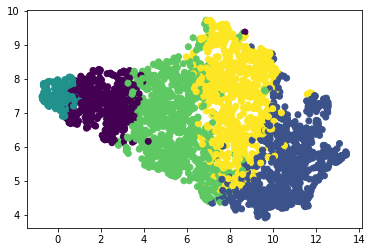

In [ ]:
reducer = umap.UMAP(verbose=0, random_state=0)
embedding = reducer.fit_transform(X)
plt.scatter(embedding[:, 0], embedding[:, 1], c=y)
plt.show()

### PCA

In order to keep more of the information carried by the original 18 variables, chose to use PCA instead of UMAP. This way, 85% of the original variance was explained by 10 principal components, greatly decreasing the dimension of the data.

In [ ]:
scaler = StandardScaler()
data_lak_clus_full_scaled = pd.DataFrame(scaler.fit_transform(data_lak_clus_full), columns=data_lak_clus_full.columns)
data_lak_clus_full_scaled.head()

label  a háztartások részére szolgáltatott villamosenergia mennyisége  \
0                                              -0.557013                
1                                               0.791423                
2                                               0.993727                
3                                              -1.131790                
4                                              -0.778544                

label  aktív keresők száma  \
0                -0.671977   
1                -0.361889   
2                -0.571586   
3                 3.976572   
4                -0.252784   

label  az összes szolgáltatott gáz mennyiségéből a háztartások részére szolgáltatott gáz mennyisége (átszámítás nélkül)  \
0                                               0.534615                                                                  
1                                              -1.482091                                                                  
2                                               0.844407                                                                  
3                                              -0.437236                                                                  
4                                              -0.365816                                                                  

label  egy éven túl nyilvántartott álláskeresők száma összesen  \
0                                              -0.728267         
1                                              -0.483076         
2                                              -0.341616         
3                                               2.255306         
4                                               0.140931         

label  elvándorlások száma  háztartási gázfogyasztók száma  \
0                -0.517836                        0.075687   
1                -0.041495                       -1.862985   
2                -0.353005                        0.714537   
3                 0.723757                        0.007873   
4                -0.205110                       -0.602137   

label  háztartási villamosenergia fogyasztók száma  \
0                                        -0.573154   
1                                         0.662283   
2                                        -0.182442   
3                                         0.779072   
4                                        -0.448961   

label  háztartásoknak szolgáltatott víz mennyisége  \
0                                        -0.117560   
1                                         0.656828   
2                                         0.498072   
3                                        -1.501669   
4                                        -0.952785   

label  időskorúak járadékára felhasznált összeg  \
0                                     -0.219405   
1                                     -0.464262   
2                                     -0.288474   
3                                     -0.464262   
4                                     -0.464262   

label  kábeltelevízió előfizetőinek száma  \
0                                0.074772   
1                               -0.947873   
2                                0.435648   
3                               -1.124073   
4                               -0.453012   

label  regisztrált munkanélküli pályakezdők száma  \
0                                       -0.354494   
1                                        0.270038   
2                                       -0.457373   
3                                       -1.091888   
4                                        0.809988   

label  regisztrált munkanélküliek száma összesen  \
0                                      -0.643333   
1                                       0.138945   
2                                      -0.560595   
3                                       2.924066   
4                                       0.418555   

label  rend

In [ ]:
X = data_lak_clus_full_scaled.iloc[:, :18]
X = X.values

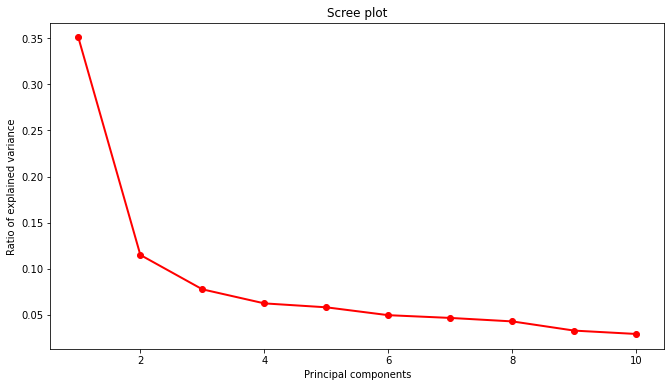

In [ ]:
pca = PCA(n_components=10)
principalComponents=pca.fit_transform(X)

PC_values = np.arange(pca.n_components_) + 1
plt.figure(figsize=(11,6))
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree plot')
plt.xlabel('Principal components')
plt.ylabel('Ratio of explained variance')
plt.show()

In [ ]:
out_sum = np.cumsum(pca.explained_variance_ratio_)  
print ("Cumulative Prop. Variance Explained: ", out_sum)

Cumulative Prop. Variance Explained:  [0.35080134 0.46582342 0.54359769 0.60612558 0.66438405 0.71411196
 0.76086347 0.80384448 0.83684192 0.8662009 ]


In [ ]:
lak_pca = pd.DataFrame(data = principalComponents, 
                  columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
lak_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.635683 -1.689709  0.113005  0.165725 -0.425211  0.448863 -0.449595   
1  0.239391  0.508631 -1.623223  0.416896  1.750217 -1.007664 -1.251240   
2  2.687530  0.075492  0.484996  0.487451  0.715303 -0.127864  0.222400   
3 -3.662096  2.330939  0.424474  2.416361 -0.394823  0.365393 -0.463145   
4 -2.417693 -0.277750 -0.608781 -0.642866 -1.911759 -0.585104  0.186332   

        PC8       PC9      PC10  
0 -0.023900  0.053257  0.082162  
1 -0.152979  0.168037  0.368731  
2  0.504970 -0.589145 -0.194370  
3  0.586687 -0.657342  0.642658  
4  0.033052 -0.619538  0.407002

### Silhoutte

As a measure of clustering quality the Silhoutte coefficient can be calculated for each datapoint. It's a number between -1 and 1, close to -1 meaning bad clustering, and close to 1 meaning an accurate one. Visualizing all the datapoints yields a distribution within clusters, that can be seen below. Here we'd like to see rougly equal sized clusters that grow towards their right signaling a large average Silhoutte coefficient.

In [ ]:
X = lak_pca.iloc[:]

##### K-means

For n_clusters = 2 The average silhouette_score is : 0.299448063870062
For n_clusters = 3 The average silhouette_score is : 0.18471727322247877
For n_clusters = 4 The average silhouette_score is : 0.194453781609574
For n_clusters = 5 The average silhouette_score is : 0.1966411882401789
For n_clusters = 6 The average silhouette_score is : 0.17784363093955471
For n_clusters = 7 The average silhouette_score is : 0.15255838837531316
For n_clusters = 8 The average silhouette_score is : 0.14093150586059278
For n_clusters = 9 The average silhouette_score is : 0.13940327157017018
For n_clusters = 10 The average silhouette_score is : 0.14375710303833852


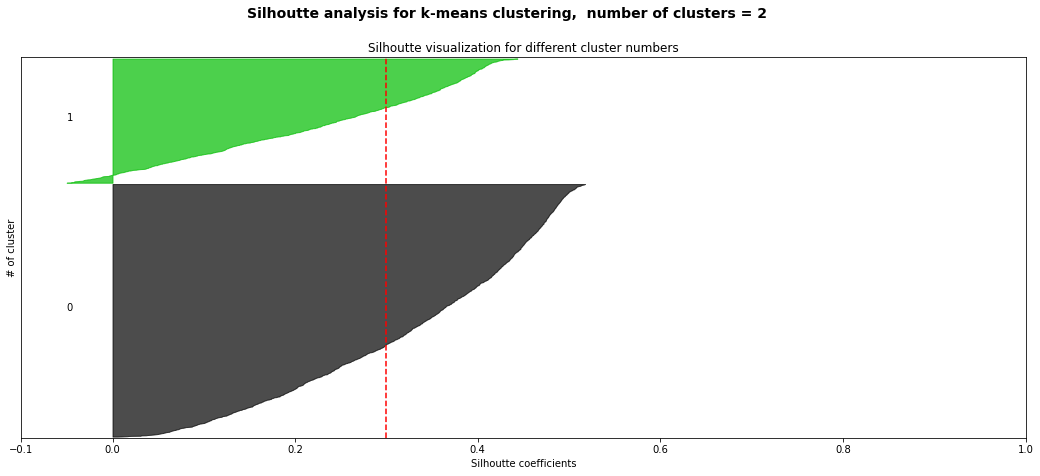

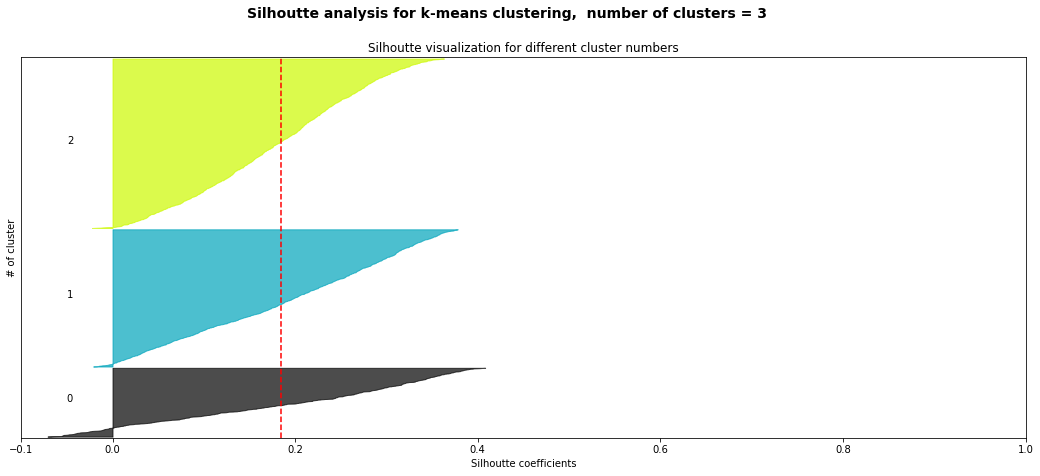

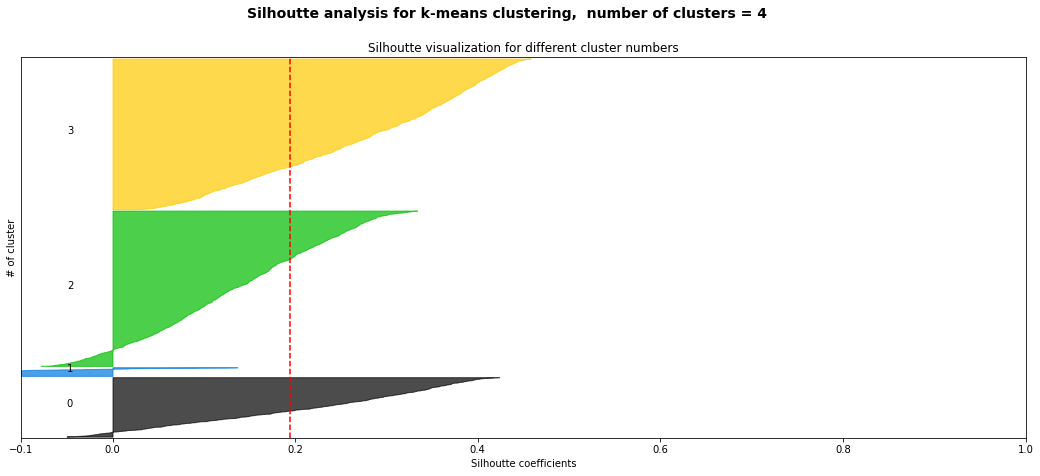

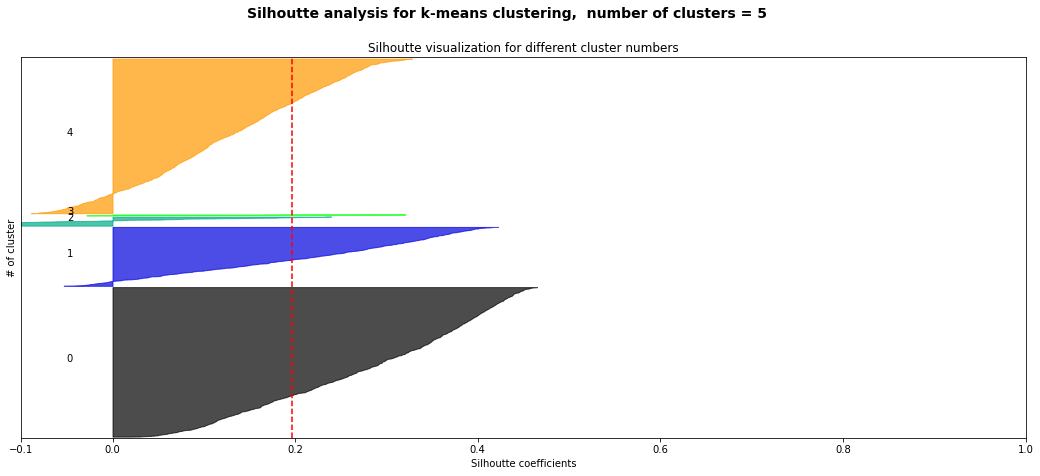

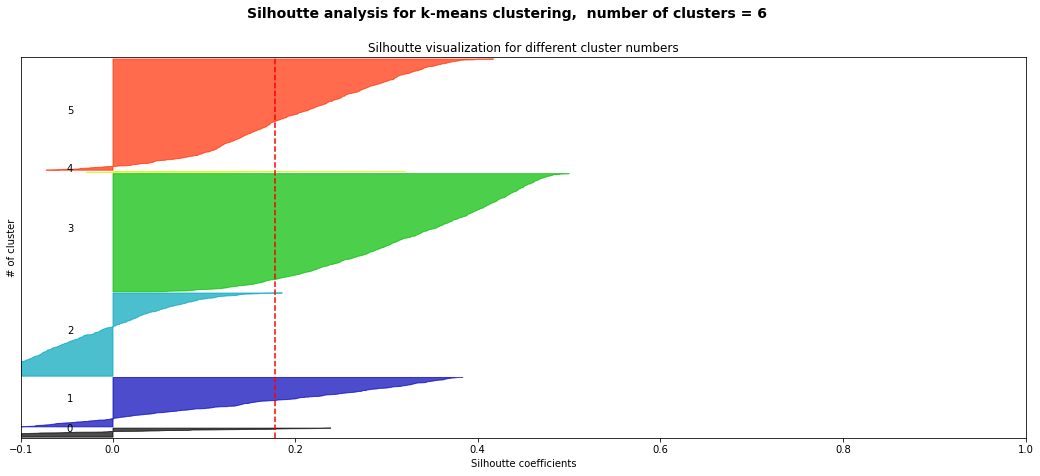

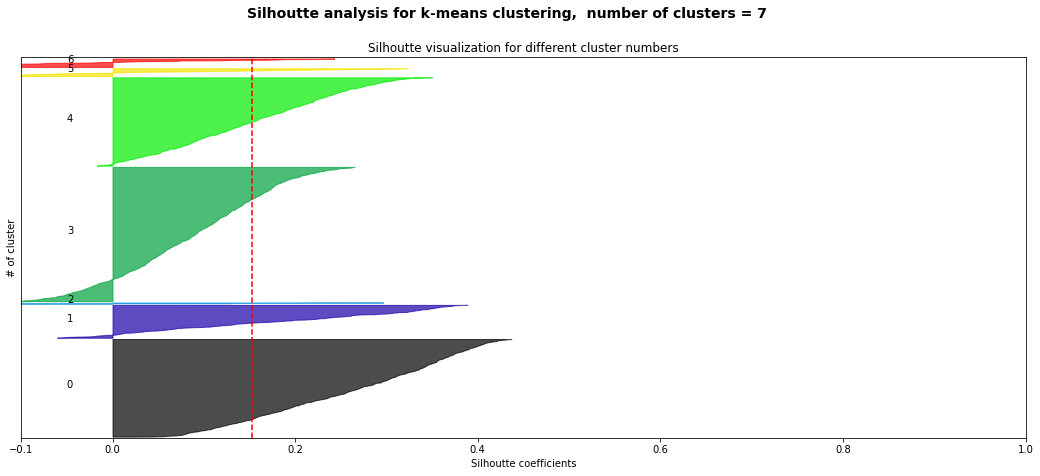

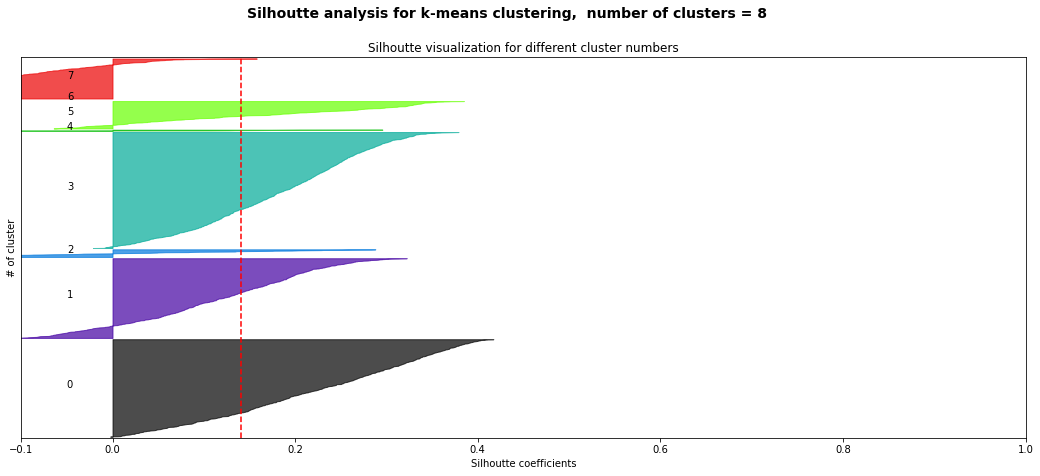

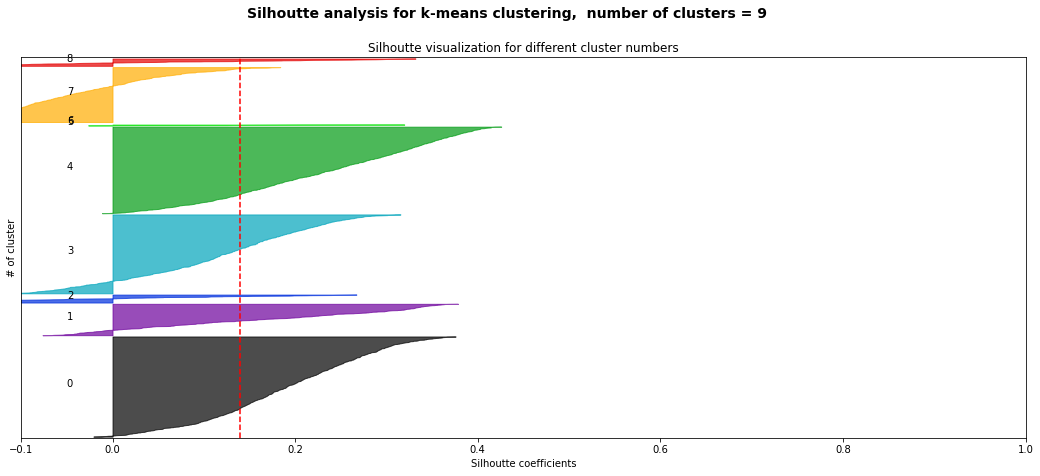

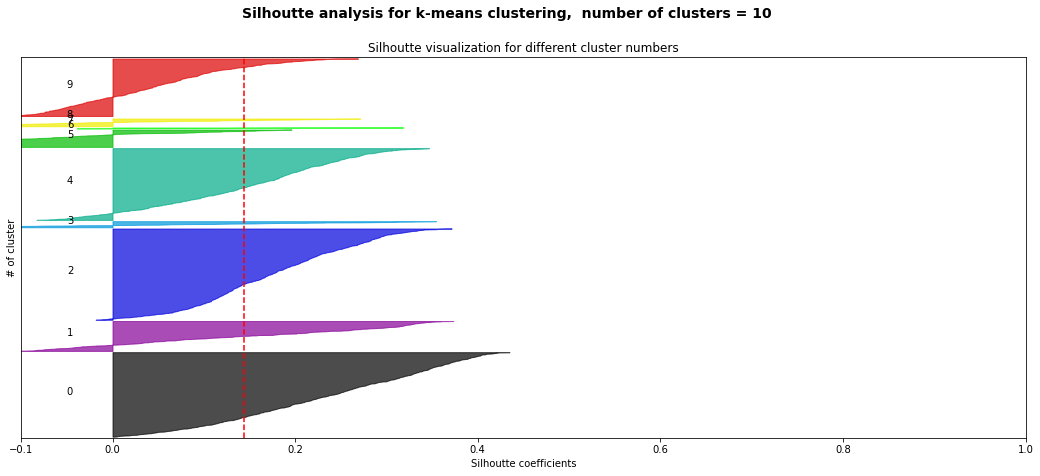

In [ ]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhoutte visualization for different cluster numbers")
    ax1.set_xlabel("Silhoutte coefficients")
    ax1.set_ylabel("# of cluster")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(("Silhoutte analysis for k-means clustering, "
                  " number of clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

##### Spectral clustering

For n_clusters = 2 The average silhouette_score is : 0.2964789378684089
For n_clusters = 3 The average silhouette_score is : 0.18051512423168986
For n_clusters = 4 The average silhouette_score is : 0.15196557201854063
For n_clusters = 5 The average silhouette_score is : 0.12847660115998263
For n_clusters = 6 The average silhouette_score is : 0.13030908376465508
For n_clusters = 7 The average silhouette_score is : 0.10828276378474332
For n_clusters = 8 The average silhouette_score is : 0.10591303402966637
For n_clusters = 9 The average silhouette_score is : 0.09290573770070171
For n_clusters = 10 The average silhouette_score is : 0.0892455989675096


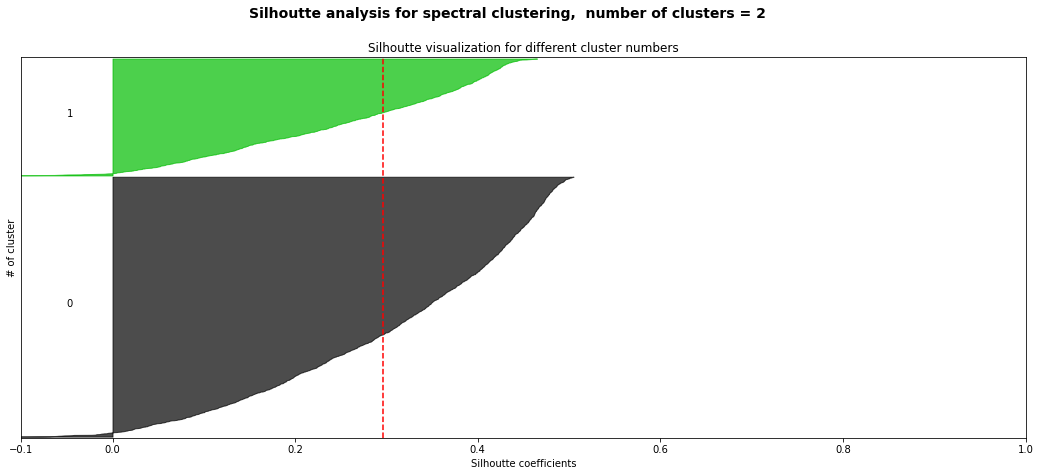

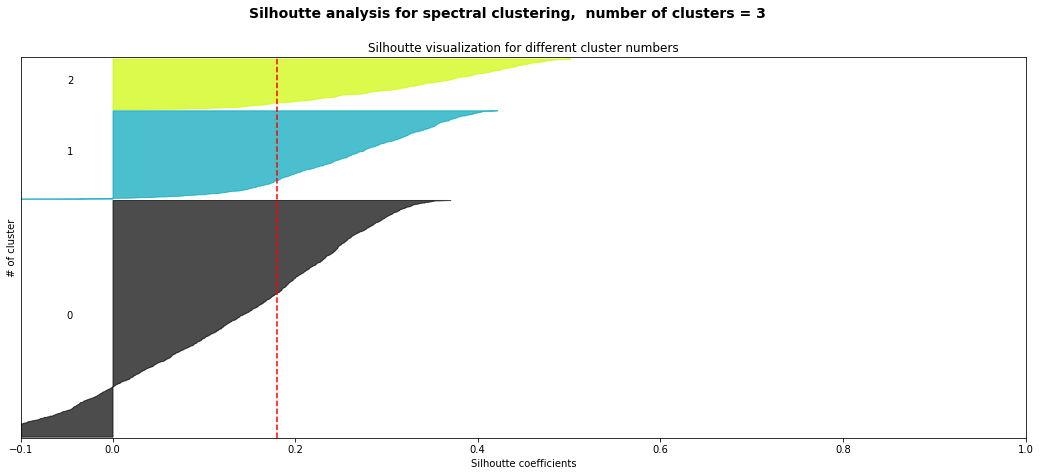

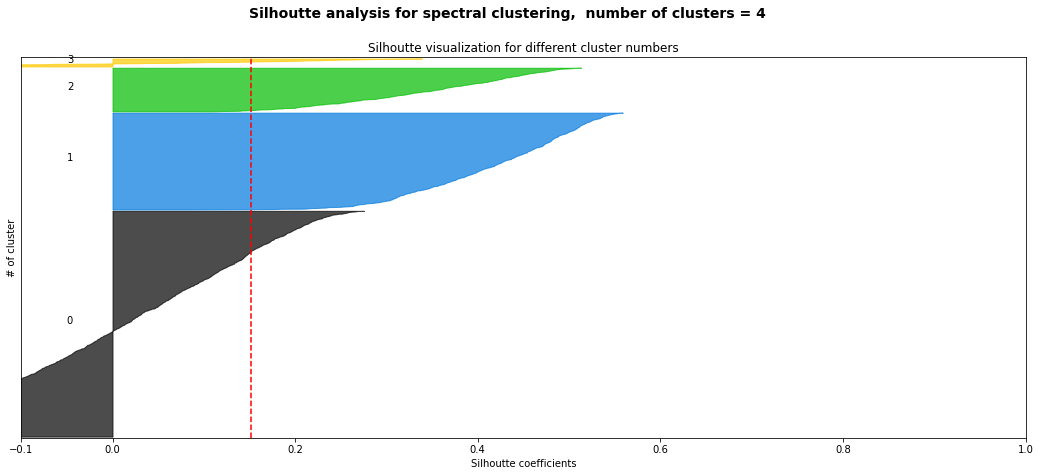

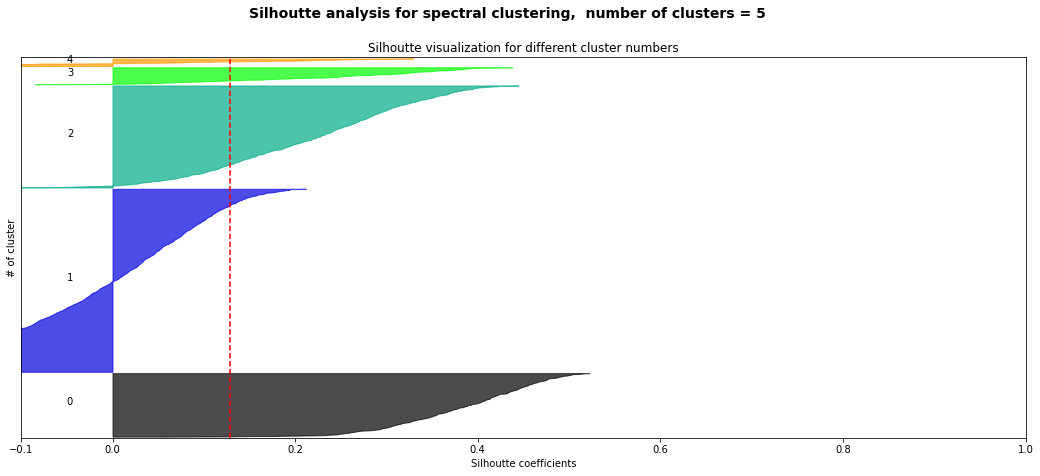

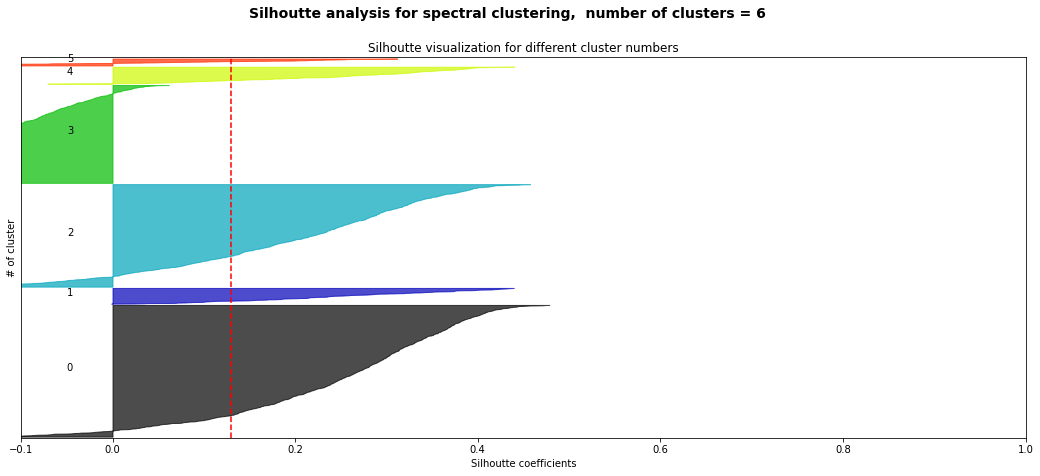

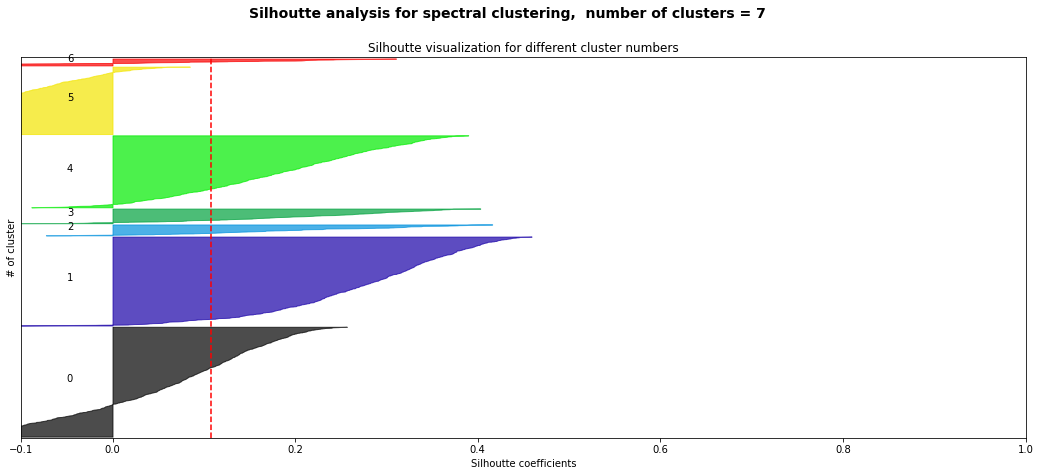

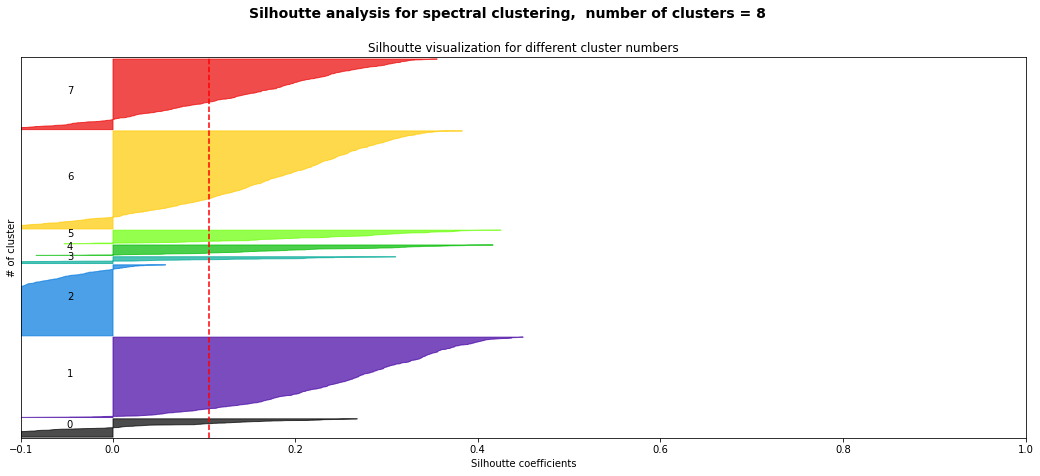

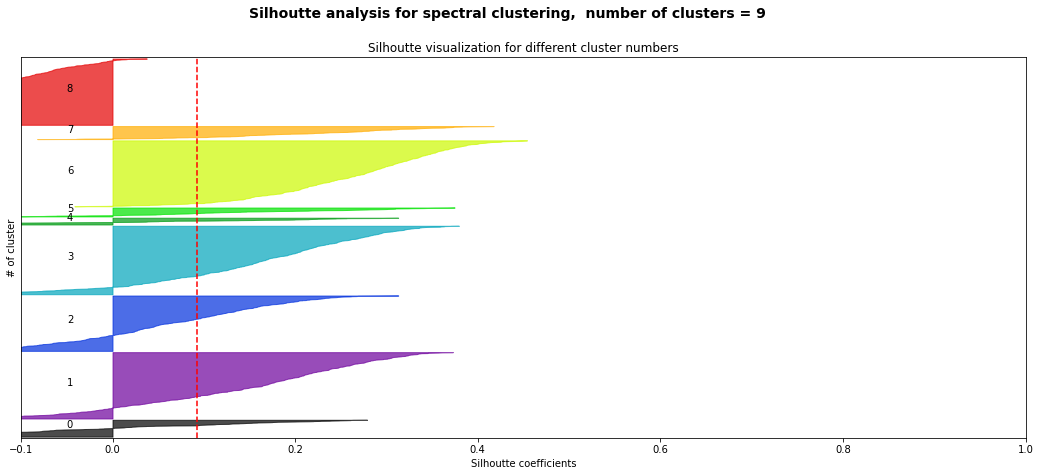

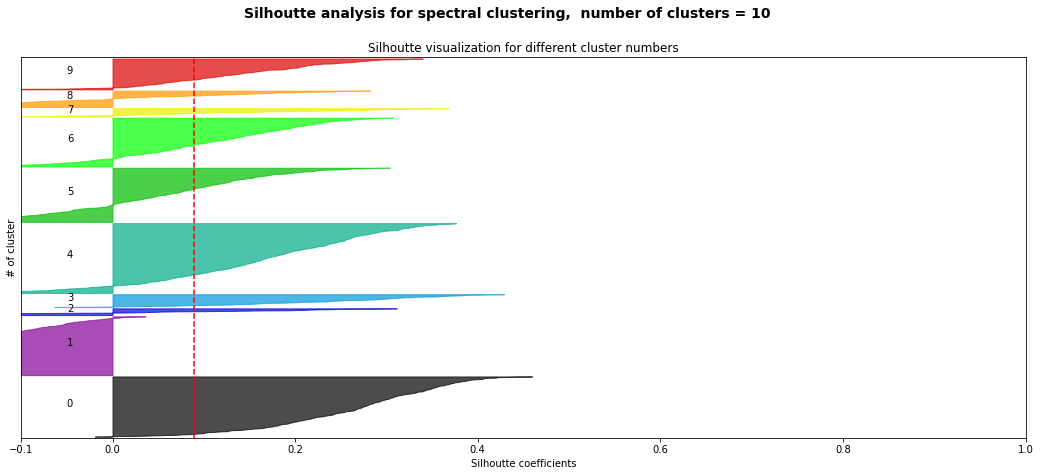

In [ ]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = SpectralClustering(
    n_clusters=n_clusters, 
    random_state=25,  
    affinity='nearest_neighbors')
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhoutte visualization for different cluster numbers")
    ax1.set_xlabel("Silhoutte coefficients")
    ax1.set_ylabel("# of cluster")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(("Silhoutte analysis for spectral clustering, "
                  " number of clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')


plt.show()

##### Hierarchical clustering

For n_clusters = 2 The average silhouette_score is : 0.28835767346781005
For n_clusters = 3 The average silhouette_score is : 0.293577543330865
For n_clusters = 4 The average silhouette_score is : 0.12148861945939297
For n_clusters = 5 The average silhouette_score is : 0.12670162471587476
For n_clusters = 6 The average silhouette_score is : 0.118926038763501
For n_clusters = 7 The average silhouette_score is : 0.12752034023158895
For n_clusters = 8 The average silhouette_score is : 0.12858805095309844
For n_clusters = 9 The average silhouette_score is : 0.1299131993329371
For n_clusters = 10 The average silhouette_score is : 0.13222519008698752


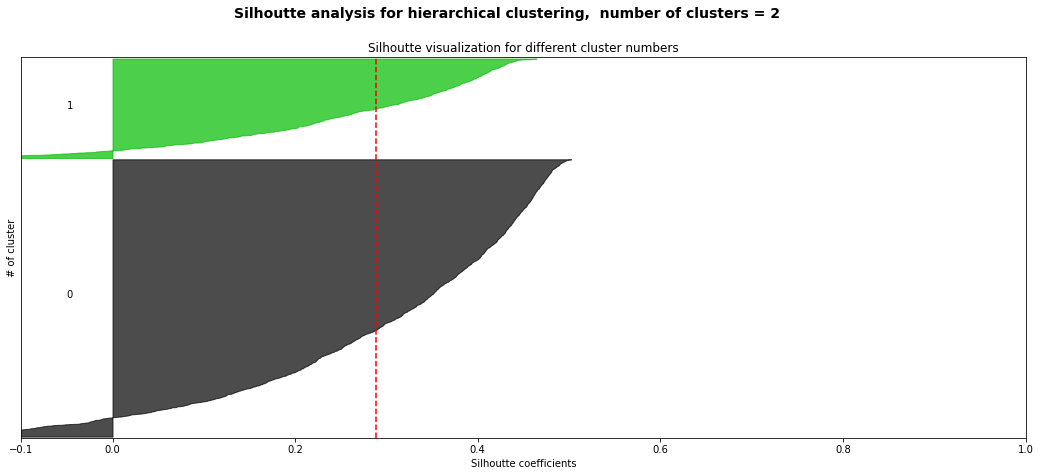

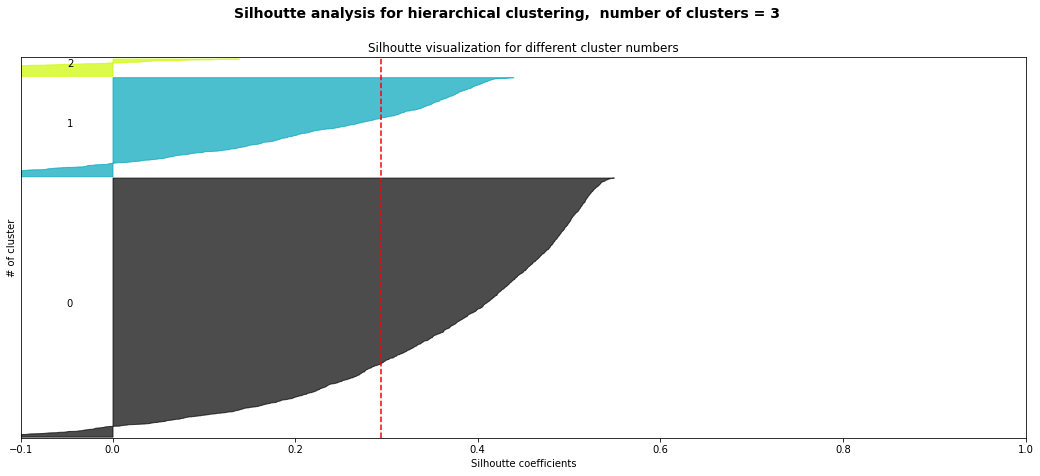

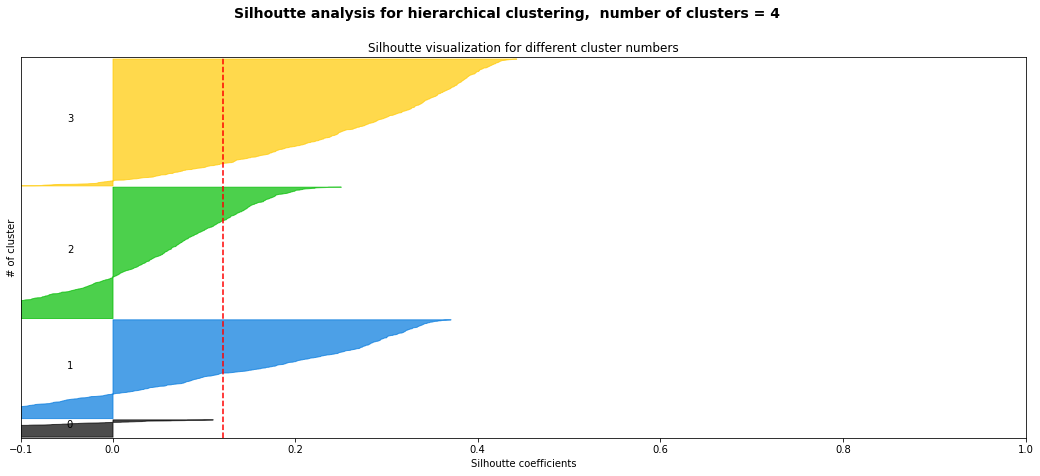

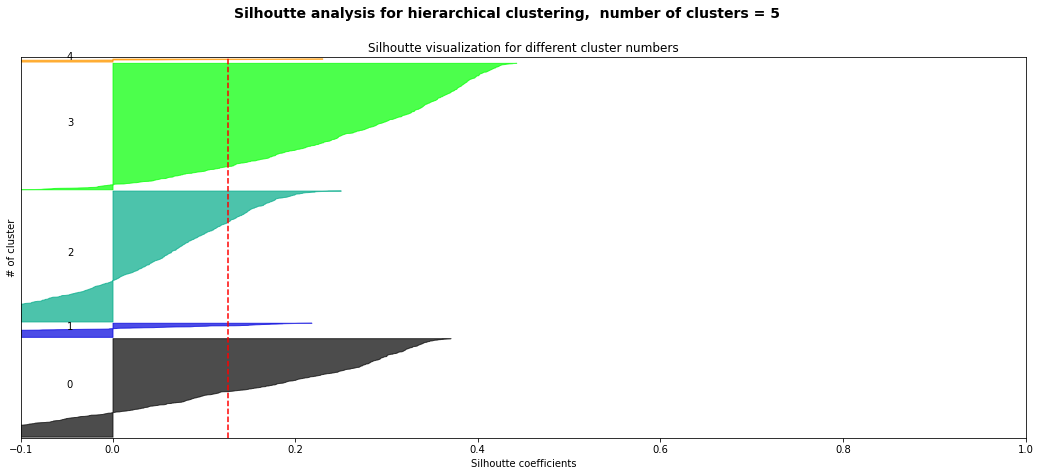

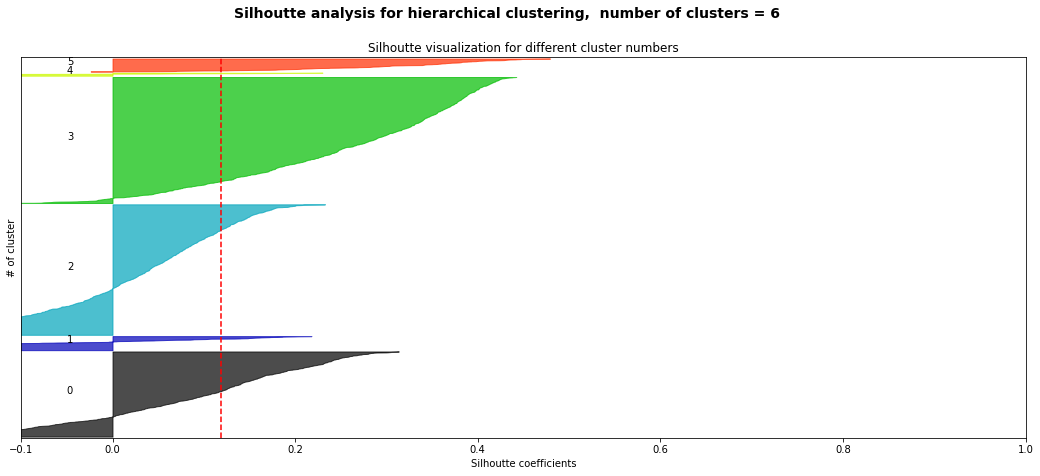

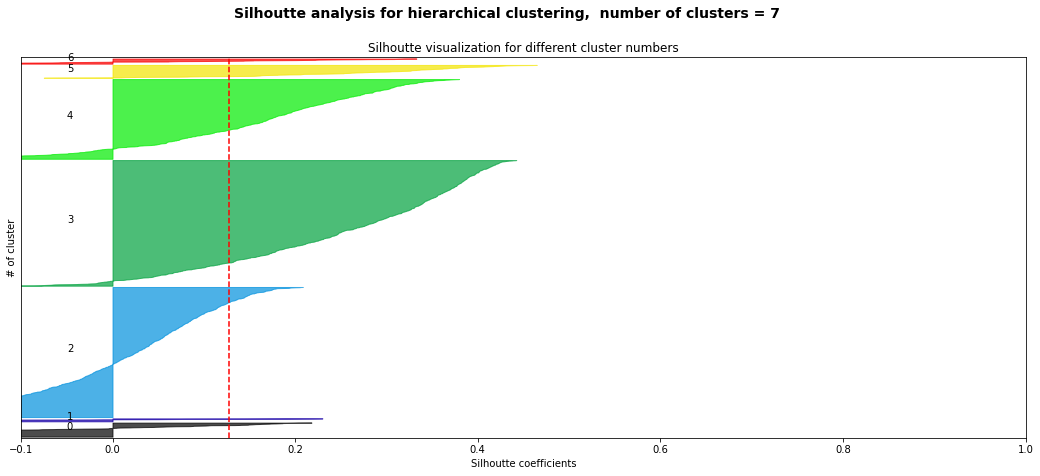

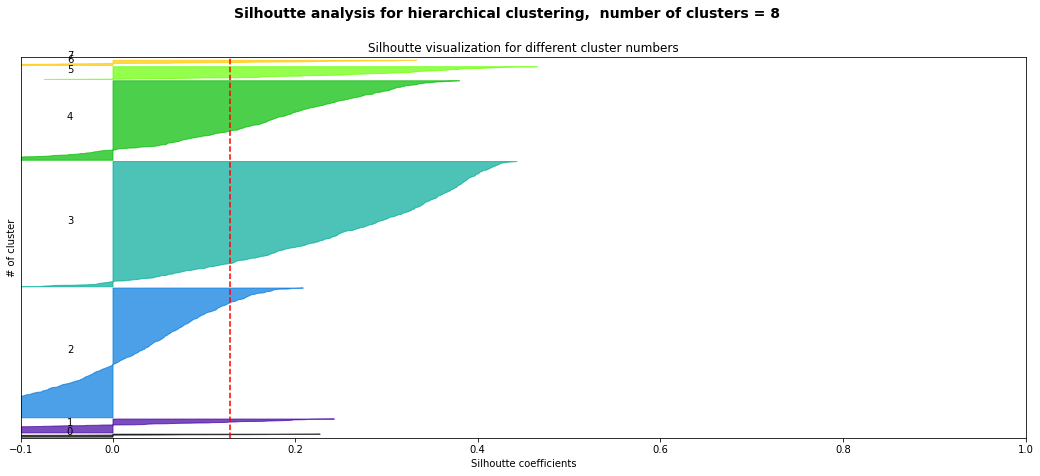

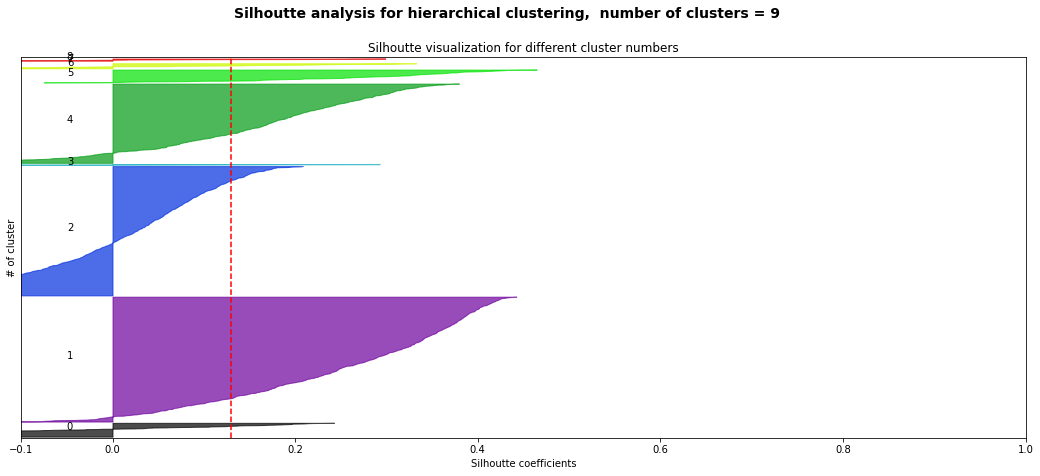

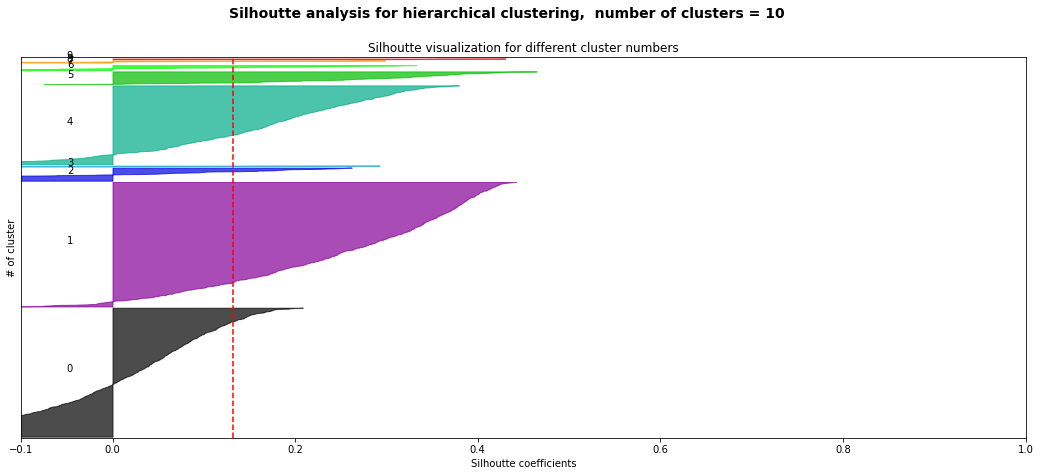

In [ ]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters = n_clusters, affinity = 'euclidean', linkage ='ward')
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhoutte visualization for different cluster numbers")
    ax1.set_xlabel("Silhoutte coefficients")
    ax1.set_ylabel("# of cluster")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(("Silhoutte analysis for hierarchical clustering, "
                  " number of clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')


plt.show()

### Cluster explanations

We have the best clustering algorithm and number for our dataset, now it's time to explain this clustering with the help of Shapley values.

##### K=5

In [ ]:
K=5


KMC=KMeans(n_clusters=K)
KMC.fit(lak_pca)
lak_pca['klaszter']=KMC.labels_

In [ ]:
X = data_lak_clus_full_scaled.iloc[:, :18]
X = X.to_numpy()
y = lak_pca['klaszter']

Cluster 4 consists of only 10 settlements. We found that these have outstanding values in 1 or more variables, hence couldn't be fitted into any other cluster.

In [ ]:
lak_pca[lak_pca['klaszter']==4]

PC1        PC2       PC3        PC4       PC5       PC6       PC7  \
81    1.302675   9.531428 -4.140060   9.438185 -8.430447  8.474845  3.014629   
532   0.095169  14.479765 -7.374059   3.750985 -5.772990  0.708058  0.271807   
793  -3.448770  23.135638 -9.985373  18.757489 -8.835179  6.894802  3.479159   
1490 -0.220540   7.393370 -3.877578   4.529492 -7.095586  3.715548 -0.486458   
1613 -1.095216  21.488147 -3.436436  13.362592  2.862083  2.554587  1.871711   
2299  0.108950   9.617834 -6.670460   6.645063 -6.434644  3.779586 -1.398860   
2660  6.725995   7.865892 -4.118193   5.837732 -0.465270  1.876588 -1.000708   
2750 -0.957557  14.566433 -7.601638   3.388552 -8.581420  3.205096 -4.686767   
2751  3.280563  11.006256 -6.655516   4.171574 -5.650012  1.776133 -0.419518   
2992  0.670223   5.581329 -3.927641   1.606466 -6.522880  2.857868 -3.358143   

           PC8        PC9      PC10  klaszter  
81   -0.387165  12.364780 -5.504698         4  
532   0.031252  -5.576020  2.673196         4  
793   3.178819  -4.440271  1.127746         4  
1490  0.500533  10.865437 -3.288082         4  
1613  3.983334  10.287941 -4.027490         4  
2299 -2.496538   3.400978 -3.340380         4  
2660  1.173852  -4.938139  4.055148         4  
2750 -3.281261  -6.949729  2.625169         4  
2751 -0.000095  -2.630848  2.275736         4  
2992 -1.192509  -7.032828  2.592333         4

In [ ]:
data_unchanged['klaszter'] = list(y)
data_unchanged[data_unchanged['klaszter']==4]

label                                               a háztartások részére szolgáltatott villamosenergia mennyisége  \
ind                                                                                                                  
(Arka, 2368, 48.3566587759573, 21.2550039258536)                                                 60.0                
(Debréte, 2932, 48.4978247736252, 20.8654470658...                                               39.0                
(Gagyapáti, 2617, 48.4100033878846, 20.99663285...                                                7.0                
(Lendvajakabfa, 929, 46.6753420672161, 16.44276...                                               28.0                
(Megyer, 293, 47.0625733701914, 17.1943569992751)                                                33.0                
(Sima, 2098, 48.3002395294024, 21.3050886391276)                                                 53.0                
(Teresztenye, 2608, 48.4453832004112, 20.609768...                                               44.0                
(Tornabarakony, 1465, 48.4924414653169, 20.8204...                                               38.0                
(Tornakápolna, 821, 48.4659680686614, 20.621218...                                               47.0                
(Zalaköveskút, 1647, 46.8479677966182, 17.14389...                                               34.0                

label                                               aktív keresők száma  \
ind                                                                       
(Arka, 2368, 48.3566587759573, 21.2550039258536)                    1.0   
(Debréte, 2932, 48.4978247736252, 20.8654470658...                  1.0   
(Gagyapáti, 2617, 48.4100033878846, 20.99663285...                  3.0   
(Lendvajakabfa, 929, 46.6753420672161, 16.44276...                  1.0   
(Megyer, 293, 47.0625733701914, 17.1943569992751)                   3.0   
(Sima, 2098, 48.3002395294024, 21.3050886391276)                    0.0   
(Teresztenye, 2608, 48.4453832004112, 20.609768...                  0.0   
(Tornabarakony, 1465, 48.4924414653169, 20.8204...                  0.0   
(Tornakápolna, 821, 48.4659680686614, 20.621218...                  0.0   
(Zalaköveskút, 1647, 46.8479677966182, 17.14389...                  0.0   

label                                               az összes szolgáltatott gáz mennyiségéből a háztartások részére szolgáltatott gáz mennyisége (átszámítás nélkül)  \
ind                                                                                                                                                                    
(Arka, 2368, 48.3566587759573, 21.2550039258536)                                                 33.0                                                                  
(Debréte, 2932, 48.4978247736252, 20.8654470658...                                                0.0                                                                  
(Gagyapáti, 2617, 48.4100033878846, 20.99663285...                                                0.0                                                                  
(Lendvajakabfa, 929, 46.6753420672161, 16.44276...                                                7.0                                                                  
(Megyer, 293, 47.0625733701914, 17.1943569992751)                                                 0.0                                                                  
(Sima, 2098, 48.3002395294024, 21.3050886391276)                                                  0.0                                                                  
(Teresztenye, 2608, 48.4453832004112, 20.609768...                                                3.0                                                                  
(Tornabarakony, 1465, 48.4924414653169, 20.8204...                                                0.0                                                                  
(T

###### 30%

We looked at different percentages of the data to approximate the Shapley values from and finally settled on 30%. This is the result that shows up in the thesis as it proved to be the most consistent across multiple runs. We checked different 10% of the data but here we experienced too much fluctuation in the resulting explanations. 20% was close, but we concluded that 30% shows a stronger picture.

In [ ]:
clusterShapley = dre.ClusterShapley()
clusterShapley.fit(X, y)

to_explain = np.array(random.sample(X.tolist(), int(X.shape[0] * 0.3)))

shap_values = clusterShapley.transform(to_explain)

Preprocessing data...
Creating summary of the background dataset...
Computing explanations...


  0%|          | 0/945 [00:00<?, ?it/s]

In [ ]:
features = list(data_lak_clus_full.columns)

Now that we have the approximations we should be able to characterize the clusters by their most important variables (that actually contribute to forming the certain clusters). We are looking for negative Shapley values, which is somewhat counterintuitive, but it comes from the original structure of the method, see the paper for more information. First cluster 0 consists of settlements with low unemployment rates.

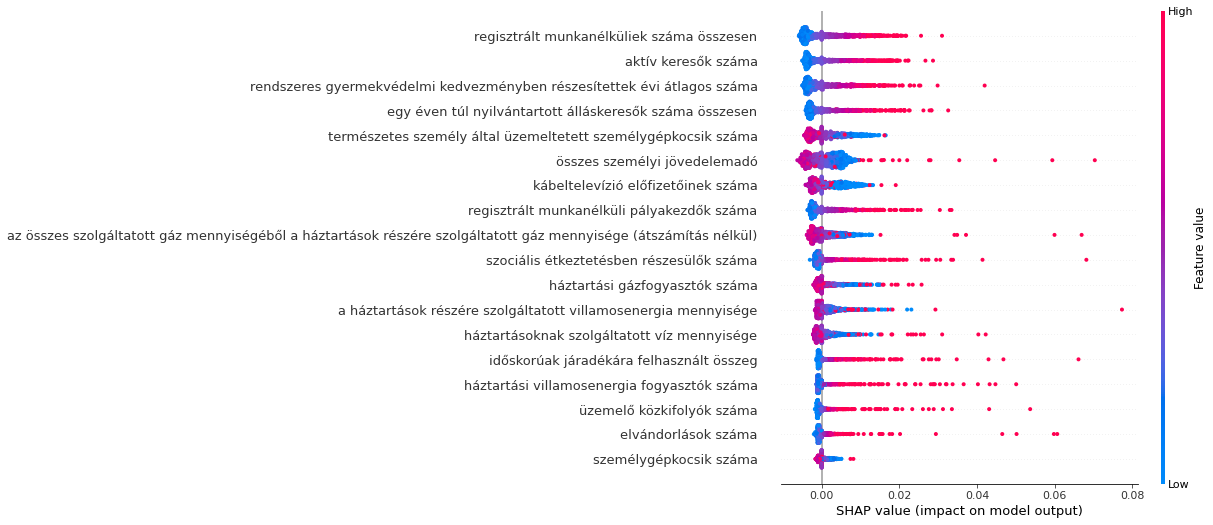

In [ ]:
osztaly = 0
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp, max_display=20)

As a counterpart to cluster 0, cluster 1 is best described by high unemployment.

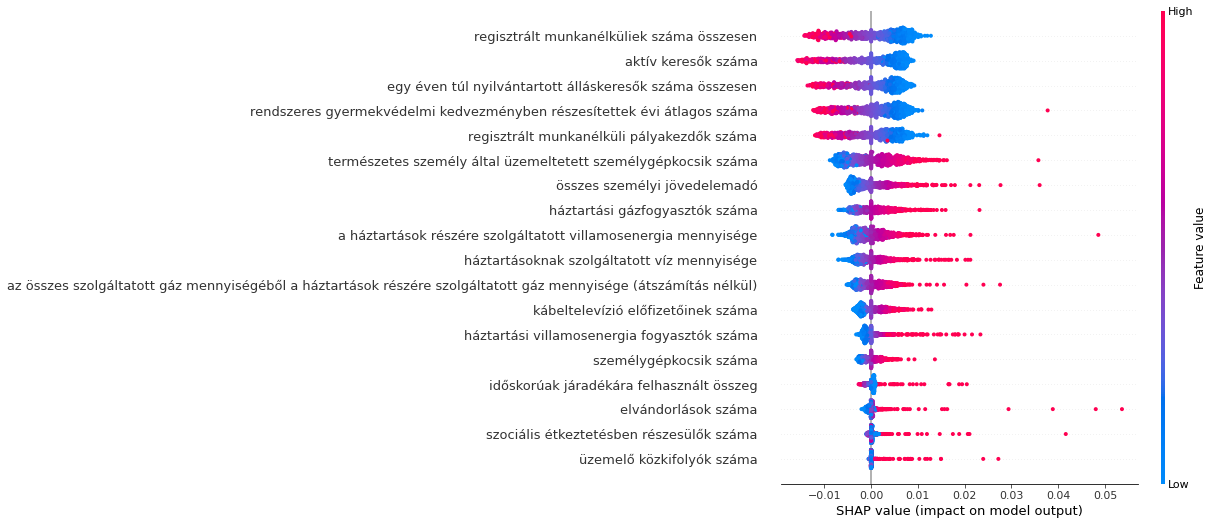

In [ ]:
osztaly = 1
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp, max_display=20)

Cluster 2 is not such a strong case, as the major variables have barely negative Shapley values, but these point out that this cluster has more or less the poorer settlements in it.

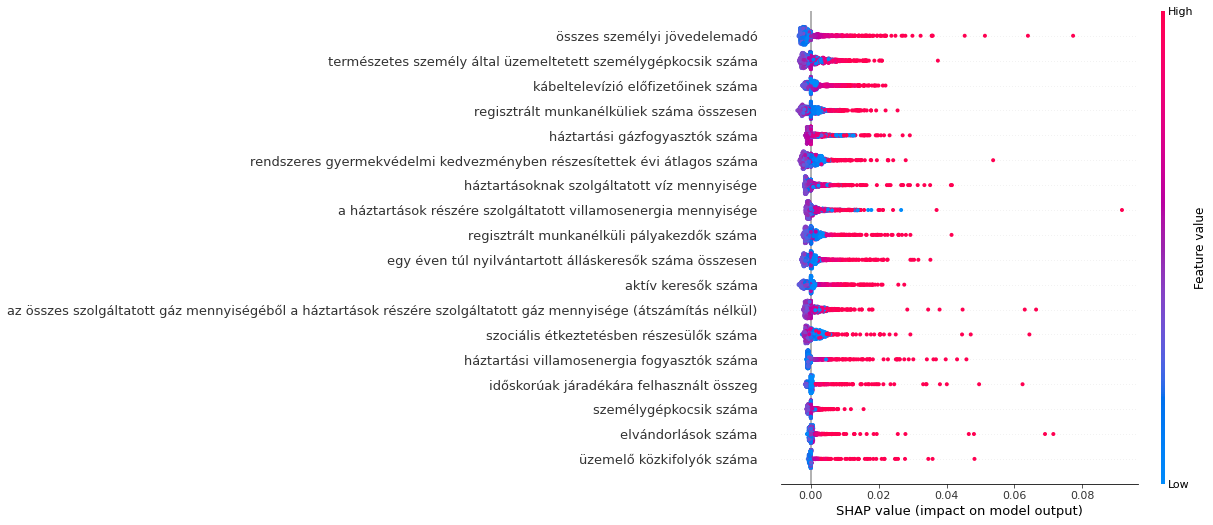

In [ ]:
osztaly = 2
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp, max_display=20)

Cluster 3 is an interesting one as first we couldn't figure out how high utilities could chategorize settlements but we had an expert help us out. He pointed out that these are mainly tourist destinations, where the "residents" are not actually the residents of the cities, but tourist who still use gas, water and electricity. As we'll see later on the map, these are settlements across the Balaton and some more scattered across the country.

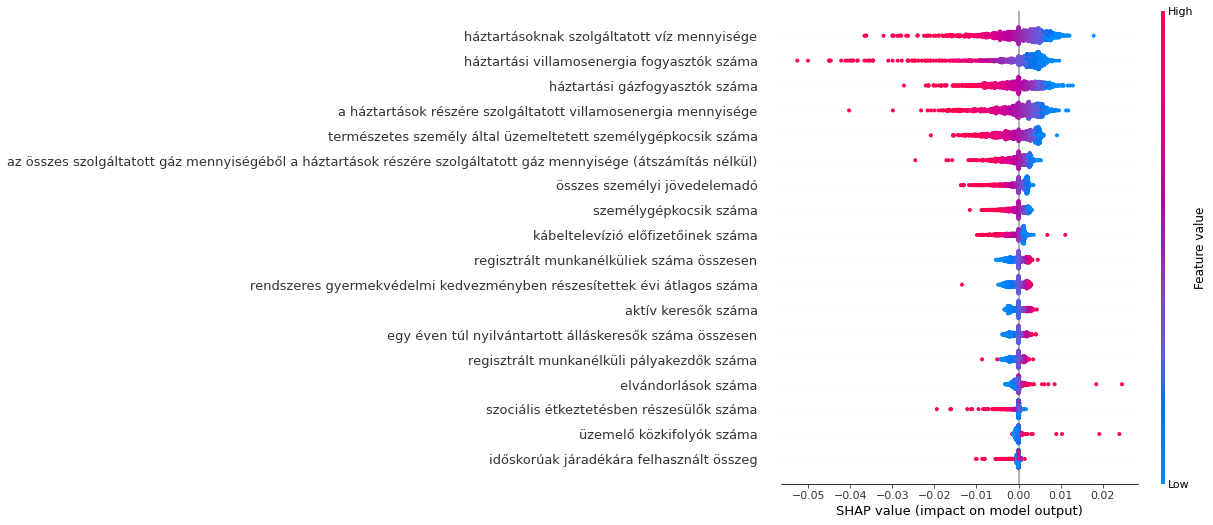

In [ ]:
osztaly = 3
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp, max_display=20)

Finally cluster 4 only has 10 settlements so here as expected nothing of substance can be read from the figure. Of course the only common attribute of these is that they're anomalies in some sense.

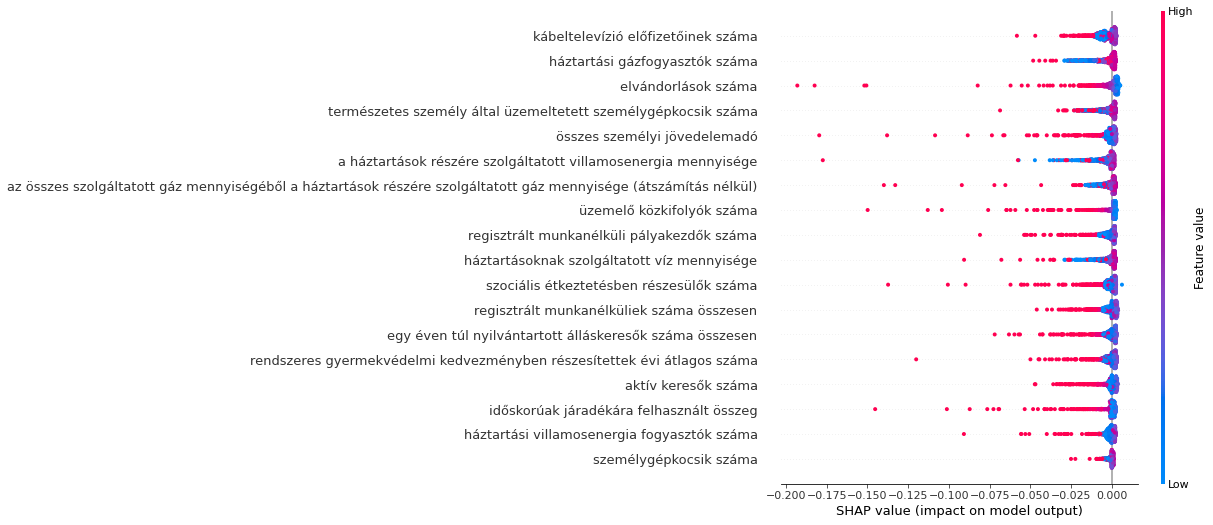

In [ ]:
osztaly = 4
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp, max_display=20)

###### **Writing the output into a geojson file**

In order to visualize the results of the clustering we used a geographical software called QGIS. With this software it is possible to print out a map of Hungary for example, where each settlement is colored according to its cluster (or any other optional variable).

In [ ]:
telepulesek=[]
for i in data_lak_clus.index.values.tolist():
  telepulesek.append(i[0])
telepulesek[:5]

In [ ]:
X = data_lak_clus_full_scaled.iloc[:, :18]
X['klaszter'] = lak_pca['klaszter']
X['name'] = telepulesek
X.head()

In [ ]:
X_geo = X.merge(geoname, on='name')
X_geo.head()

In [ ]:
file_old = '/content/drive/My Drive/Temalabor1/momap.geojson'
file_new = '/content/drive/My Drive/Diplomamunka/klaszter5_2010_lak_uj.geojson'

import json
with open(file_old, 'r') as f:
    data = json.load(f)

for feature in data['features']:
    geoid2 = feature['properties']['geoid']
    if len(X_geo[X_geo['geoid'] == geoid2]['klaszter']) == 0:
      del feature
    else:
      feature['properties']['klaszter'] = X_geo[X_geo.geoid == geoid2]['klaszter'].item()
      feature['properties']['varos'] = str(X_geo[X_geo.geoid == geoid2]['name'].item())

with open(file_new, 'w+') as f:
    json.dump(data, f, indent=2)

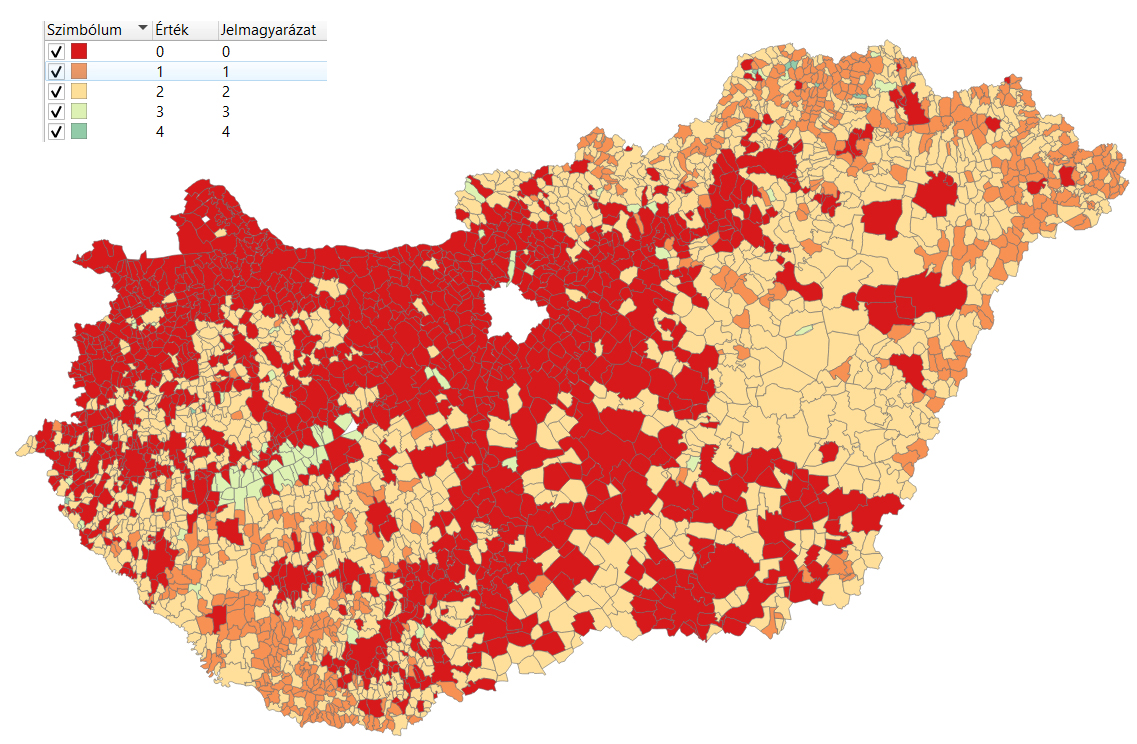

In [ ]:
Image('terkep_k5_lak_jelmagy.jpg')

###### 20%

The following analysis (20 and 10% cases) is the repetition of the previous 30% case, which we did to ensure we actually have to use 30% to get consistent results.

In [ ]:
lak_pca = pd.DataFrame(data = principalComponents, 
                  columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])

K=5

KMC=KMeans(n_clusters=K)
KMC.fit(lak_pca)
lak_pca['klaszter']=KMC.labels_

In [ ]:
X = data_lak_clus_full_scaled.iloc[:, :18]
X = X.to_numpy()
y = lak_pca['klaszter']

In [ ]:
clusterShapley = dre.ClusterShapley()
clusterShapley.fit(X, y)

to_explain = np.array(random.sample(X.tolist(), int(X.shape[0] * 0.2)))

shap_values = clusterShapley.transform(to_explain)

Preprocessing data...
Creating summary of the background dataset...
Computing explanations...


  0%|          | 0/630 [00:00<?, ?it/s]

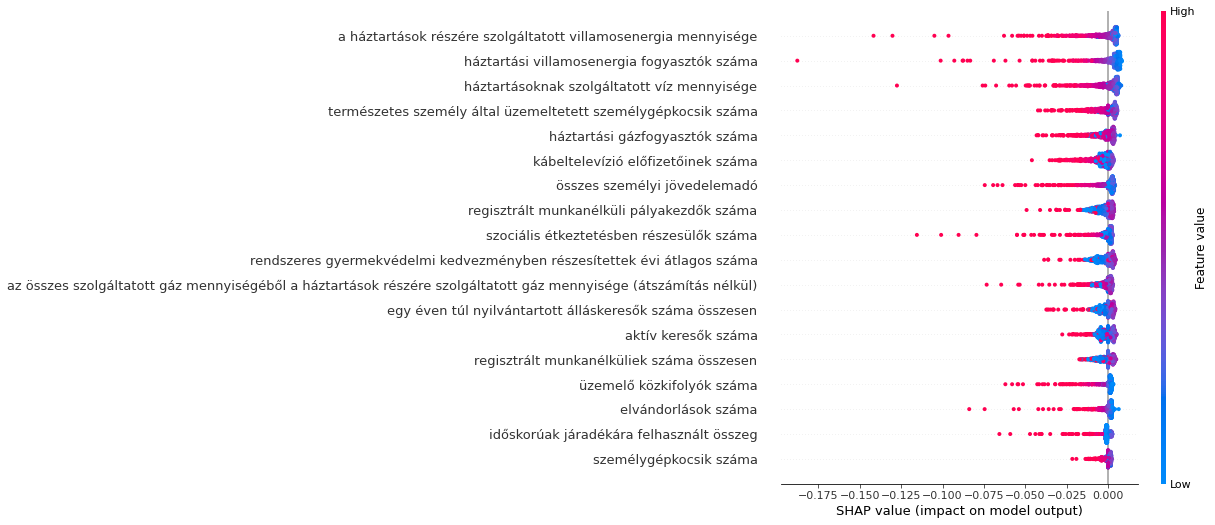

In [ ]:
osztaly = 0
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp, max_display=20)

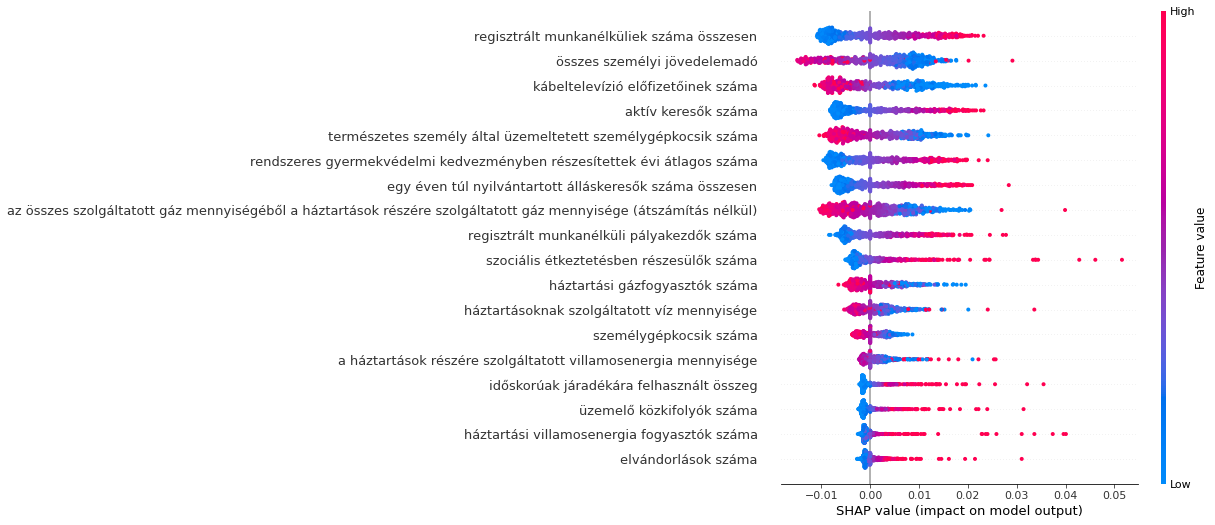

In [ ]:
osztaly = 1
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp, max_display=20)

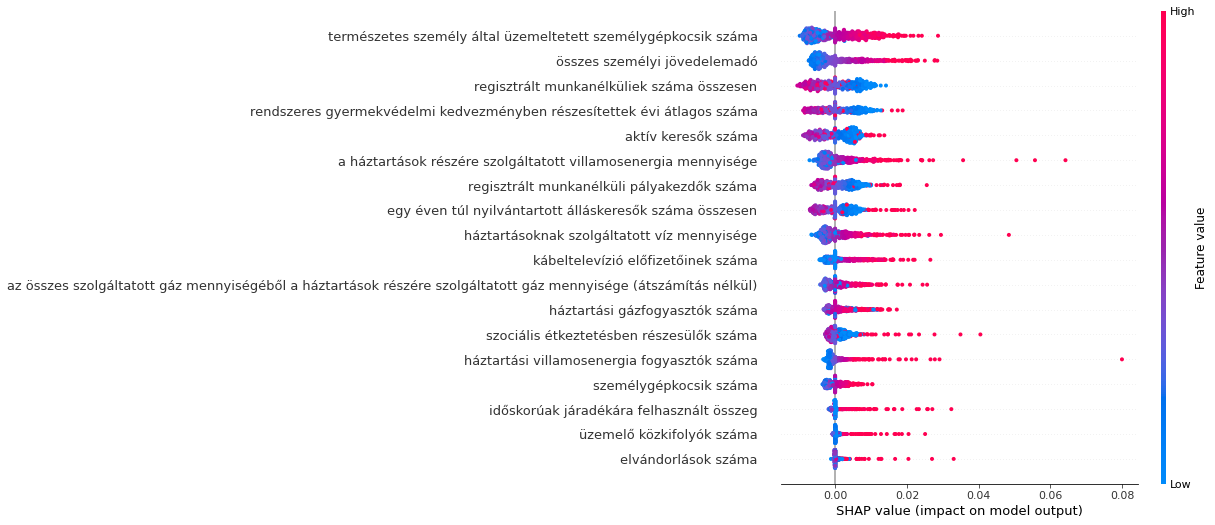

In [ ]:
osztaly = 2
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp, max_display=20)

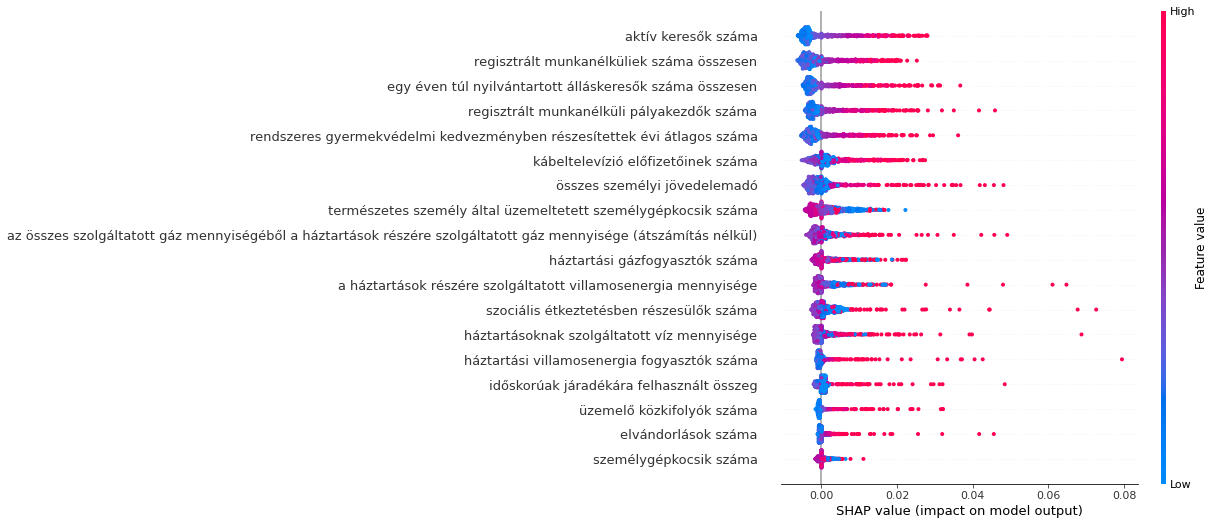

In [ ]:
osztaly = 3
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp, max_display=20)

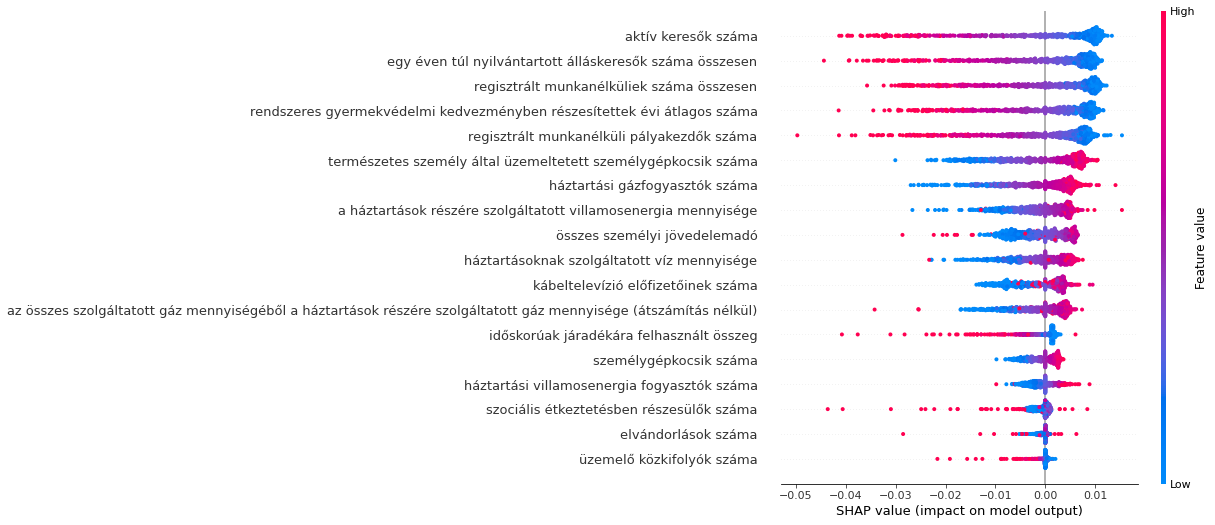

In [ ]:
osztaly = 4
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp, max_display=20)

###### 10%

In [ ]:
lak_pca = pd.DataFrame(data = principalComponents, 
                  columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])

K=5

KMC=KMeans(n_clusters=K)
KMC.fit(lak_pca)
lak_pca['klaszter']=KMC.labels_

In [ ]:
X = data_lak_clus_full_scaled.iloc[:, :18]
X = X.to_numpy()
y = lak_pca['klaszter']

In [ ]:
clusterShapley = dre.ClusterShapley()
clusterShapley.fit(X, y)

to_explain = np.array(random.sample(X.tolist(), int(X.shape[0] * 0.1)))

shap_values = clusterShapley.transform(to_explain)

Preprocessing data...
Creating summary of the background dataset...
Computing explanations...


  0%|          | 0/315 [00:00<?, ?it/s]

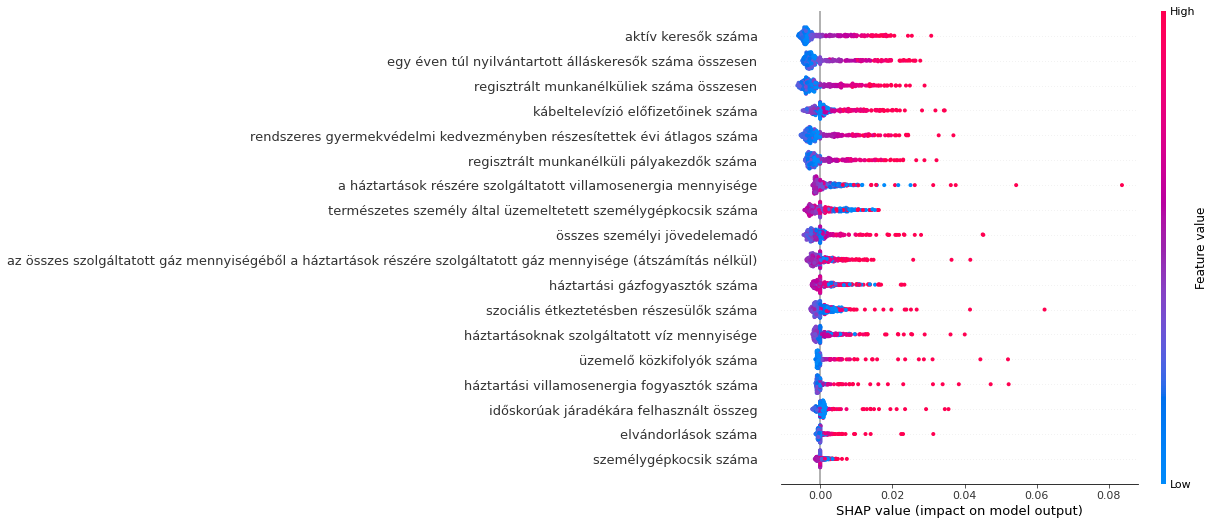

In [ ]:
osztaly = 0
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp, max_display=20)

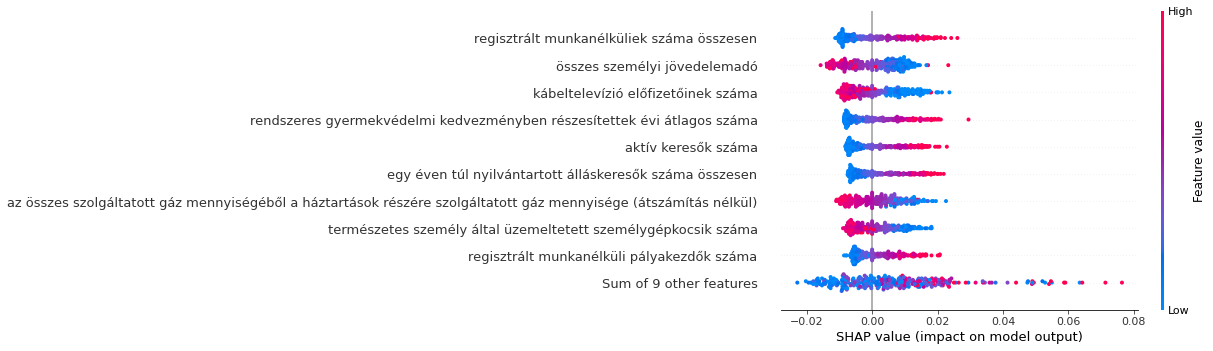

In [ ]:
osztaly = 1
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp)

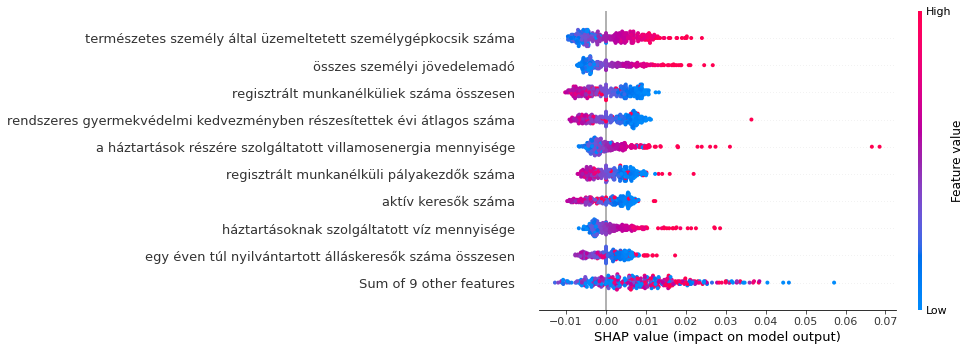

In [ ]:
osztaly = 2
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp)

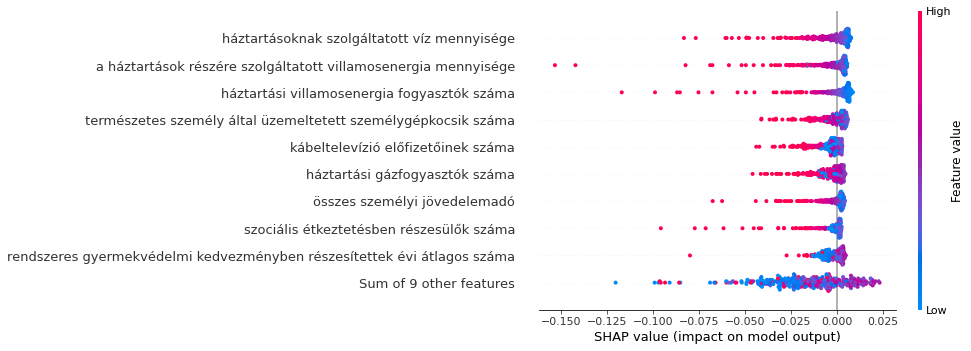

In [ ]:
osztaly = 3
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp)

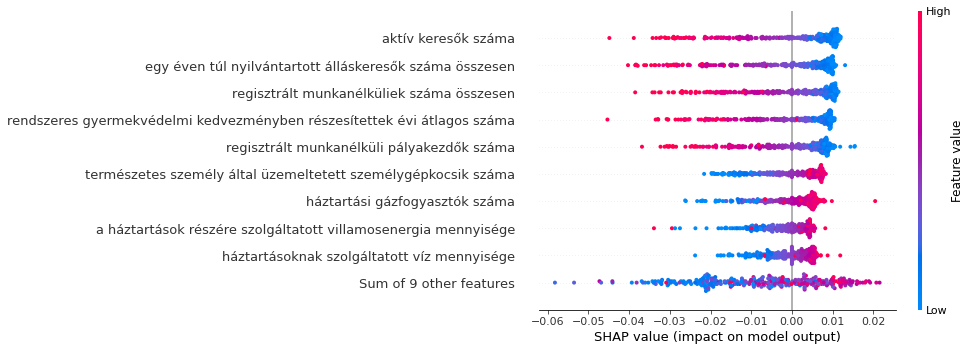

In [ ]:
osztaly = 4
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp)

###### **Disjoint 10%**

We also checked the effect of randomisation during the initialization of the cluster centroids. Since this results in slightly different clusters, we might expect different results. Also we looked at different settlements, hence the disjoint 10% name. The point of this was to check how consistent the method is, and if it is enough to only look at 10% of the data when approximating the Shapley values.

In [ ]:
lak_pca = pd.DataFrame(data = principalComponents, 
                  columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])

K=5

KMC=KMeans(n_clusters=K)
KMC.fit(lak_pca)
lak_pca['klaszter']=KMC.labels_

In [ ]:
X = data_lak_clus_full_scaled.iloc[:, :18]
X = X.to_numpy()
y = lak_pca['klaszter']

In [ ]:
clusterShapley = dre.ClusterShapley()
clusterShapley.fit(X, y)

to_explain = np.array(X.tolist()[:315])

shap_values = clusterShapley.transform(to_explain)

Preprocessing data...
Creating summary of the background dataset...
Computing explanations...


  0%|          | 0/315 [00:00<?, ?it/s]

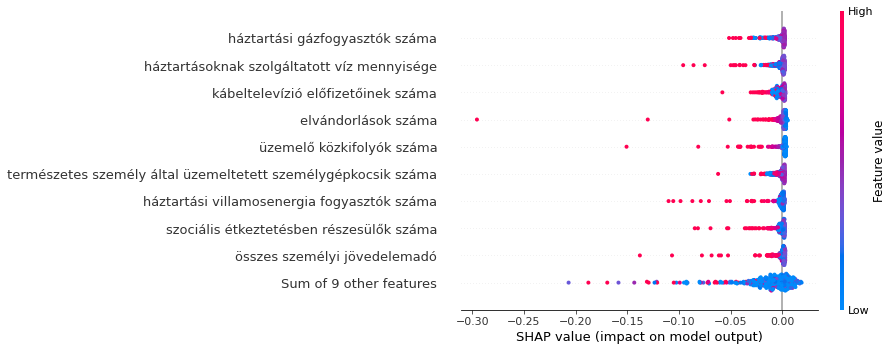

In [ ]:
osztaly = 0
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp)

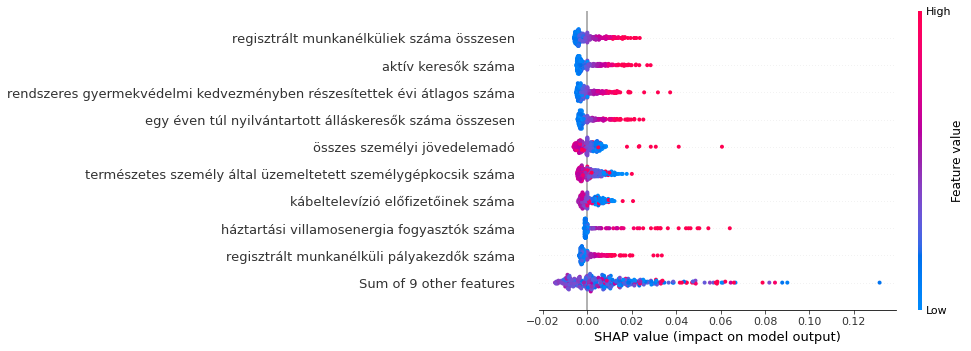

In [ ]:
osztaly = 1
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp)

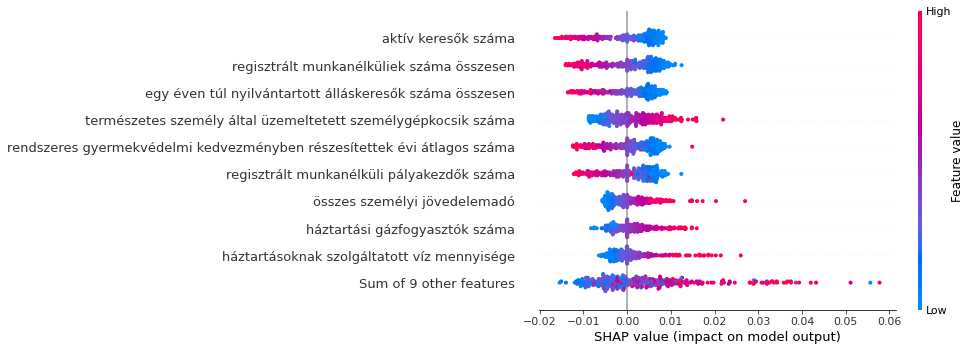

In [ ]:
osztaly = 2
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp)

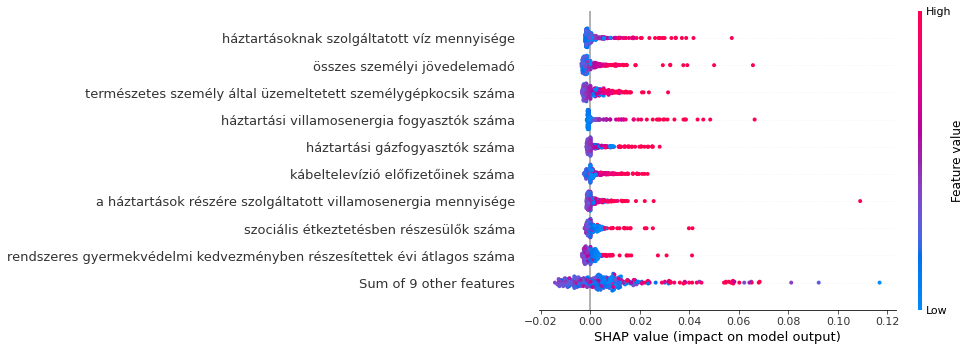

In [ ]:
osztaly = 3
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp)

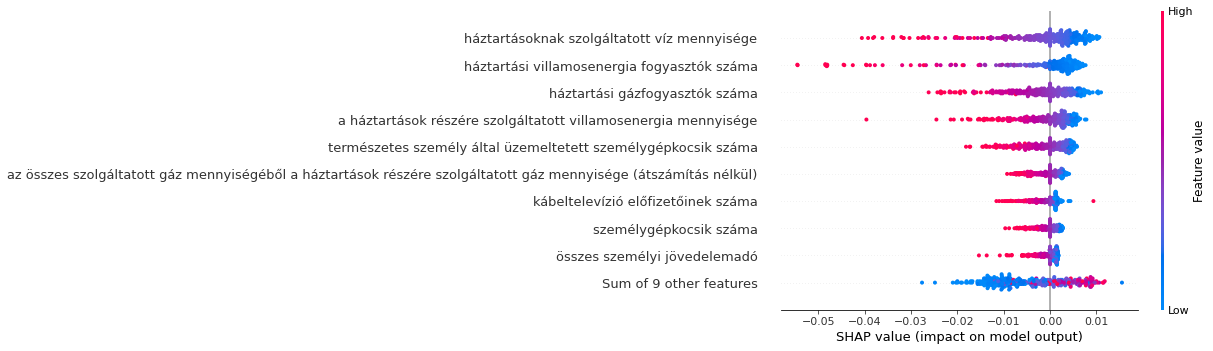

In [ ]:
osztaly = 4
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp)

The second disjoint 10%

In [ ]:
lak_pca = pd.DataFrame(data = principalComponents, 
                  columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])

K=5

KMC=KMeans(n_clusters=K)
KMC.fit(lak_pca)
lak_pca['klaszter']=KMC.labels_

In [ ]:
X = data_lak_clus_full_scaled.iloc[:, :18]
X = X.to_numpy()
y = lak_pca['klaszter']

In [ ]:
clusterShapley = dre.ClusterShapley()
clusterShapley.fit(X, y)

to_explain = np.array(X.tolist()[315:630])

shap_values = clusterShapley.transform(to_explain)

Preprocessing data...
Creating summary of the background dataset...
Computing explanations...


  0%|          | 0/315 [00:00<?, ?it/s]

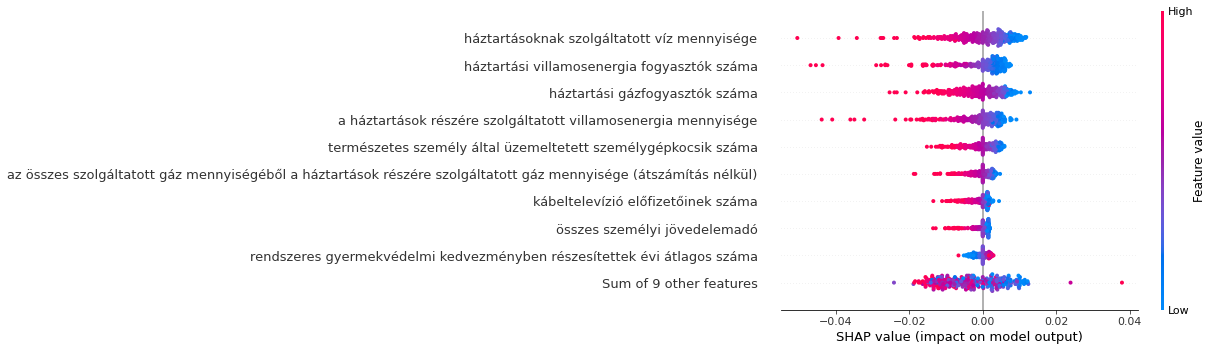

In [ ]:
osztaly = 0
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp)

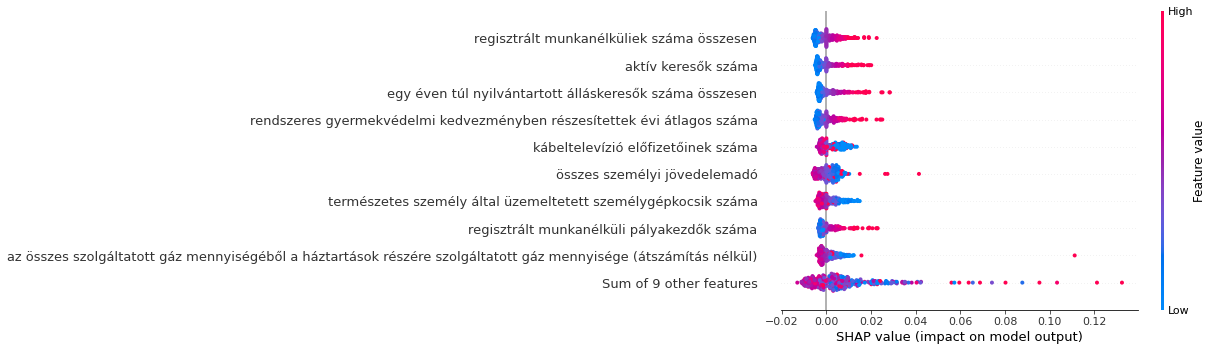

In [ ]:
osztaly = 1
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp)

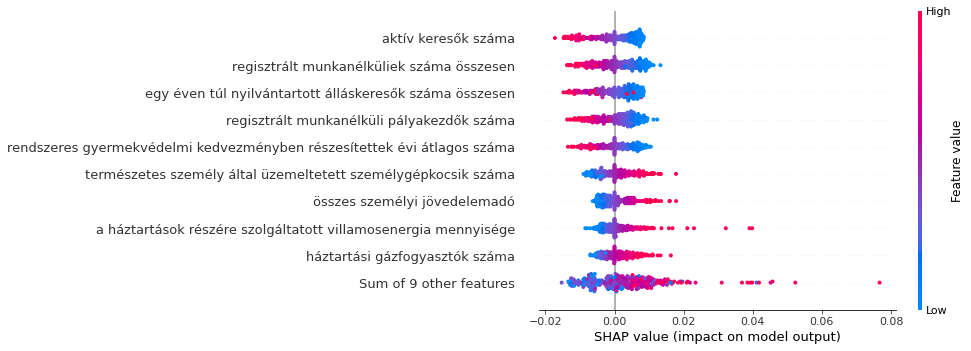

In [ ]:
osztaly = 2
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp)

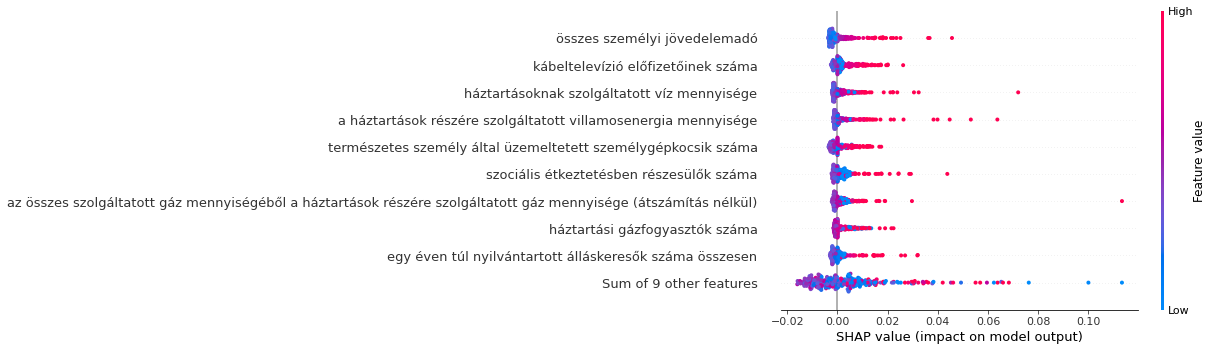

In [ ]:
osztaly = 3
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp)

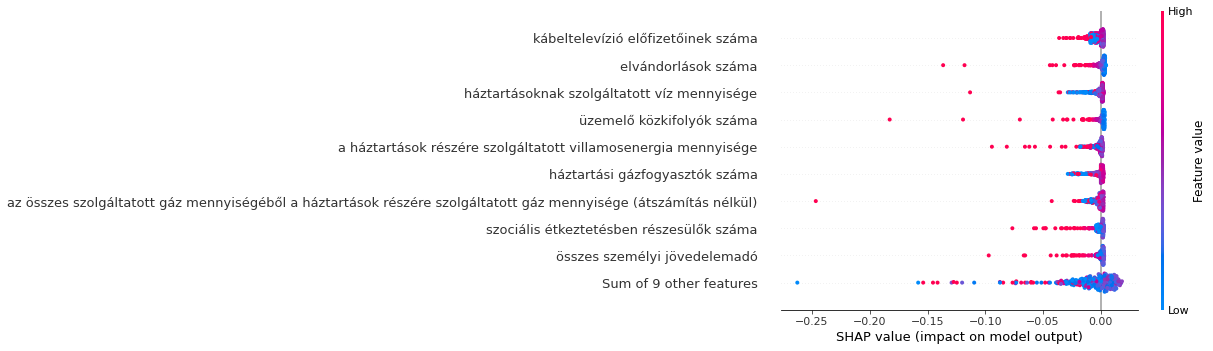

In [ ]:
osztaly = 4
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp)

The third disjoint 10%

In [ ]:
lak_pca = pd.DataFrame(data = principalComponents, 
                  columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])

K=5

KMC=KMeans(n_clusters=K)
KMC.fit(lak_pca)
lak_pca['klaszter']=KMC.labels_

In [ ]:
X = data_lak_clus_full_scaled.iloc[:, :18]
X = X.to_numpy()
y = lak_pca['klaszter']

In [ ]:
clusterShapley = dre.ClusterShapley()
clusterShapley.fit(X, y)

to_explain = np.array(X.tolist()[630:945])

shap_values = clusterShapley.transform(to_explain)

Preprocessing data...
Creating summary of the background dataset...
Computing explanations...


  0%|          | 0/315 [00:00<?, ?it/s]

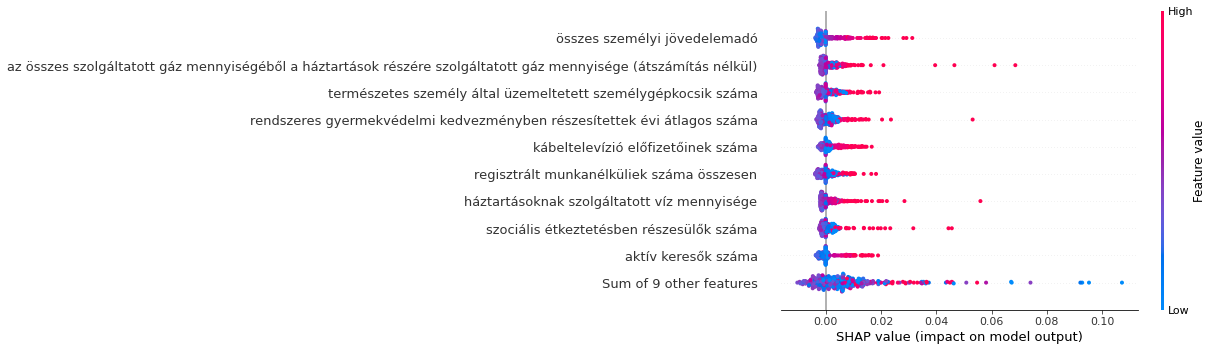

In [ ]:
osztaly = 0
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp)

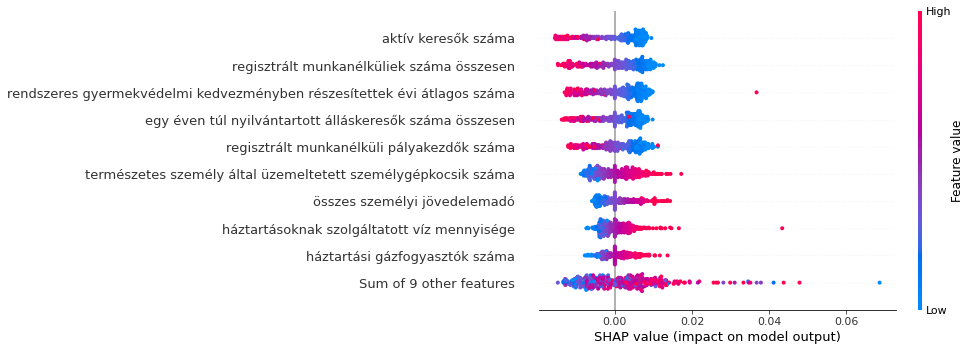

In [ ]:
osztaly = 1
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp)

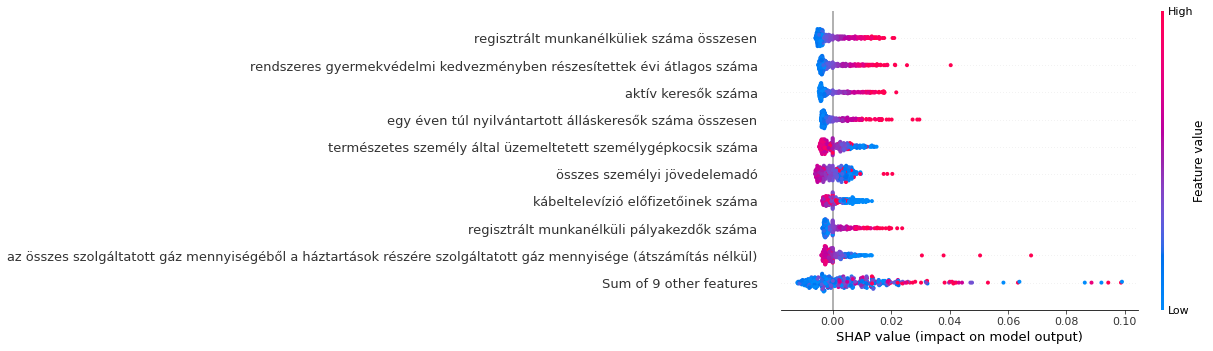

In [ ]:
osztaly = 2
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp)

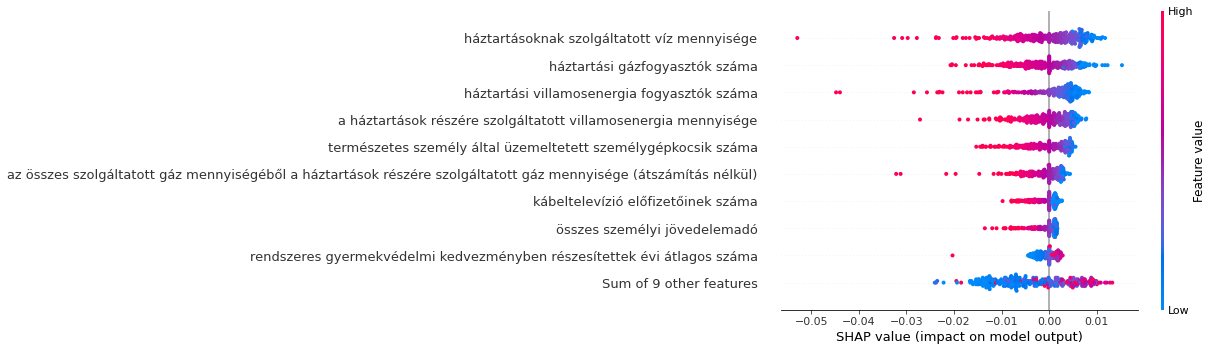

In [ ]:
osztaly = 3
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp)

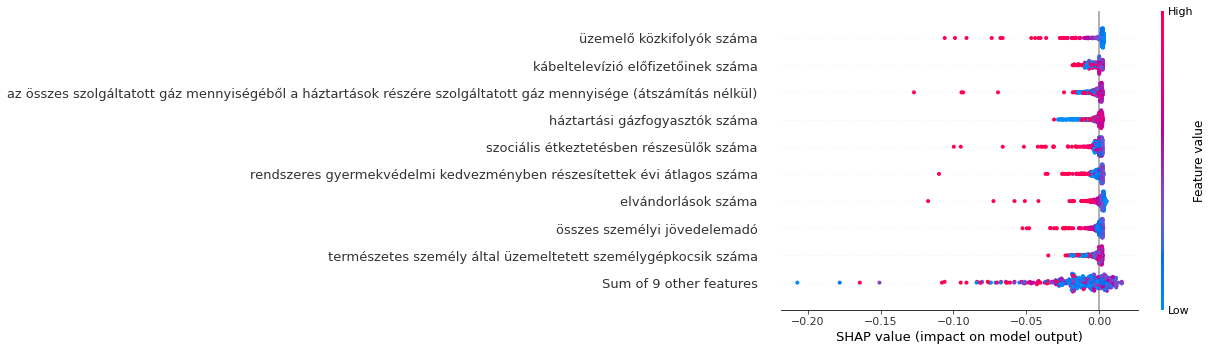

In [ ]:
osztaly = 4
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp)

We can conclude that there are core clusters which remain consistent, altough there are some smaller clusters where the results vary drastically. But that is expected, since a cluster of ~10 settlements is hard to characterize.

##### K=3

Also checked the results with 3 clusters, even though we had a feeling this number is too low for more than 3000 settlements.

In [ ]:
K=3


KMC=KMeans(n_clusters=K)
KMC.fit(lak_pca)
lak_pca['klaszter']=KMC.labels_

In [ ]:
X = data_lak_clus_full_scaled.iloc[:, :18]
X = X.to_numpy()
y = lak_pca['klaszter']

In [ ]:
clusterShapley = dre.ClusterShapley()
clusterShapley.fit(X, y)

to_explain = np.array(random.sample(X.tolist(), int(X.shape[0] * 0.1)))

shap_values = clusterShapley.transform(to_explain)

Preprocessing data...
Creating summary of the background dataset...
Computing explanations...


  0%|          | 0/315 [00:00<?, ?it/s]

In [ ]:
features = list(data_lak_clus_full.columns)

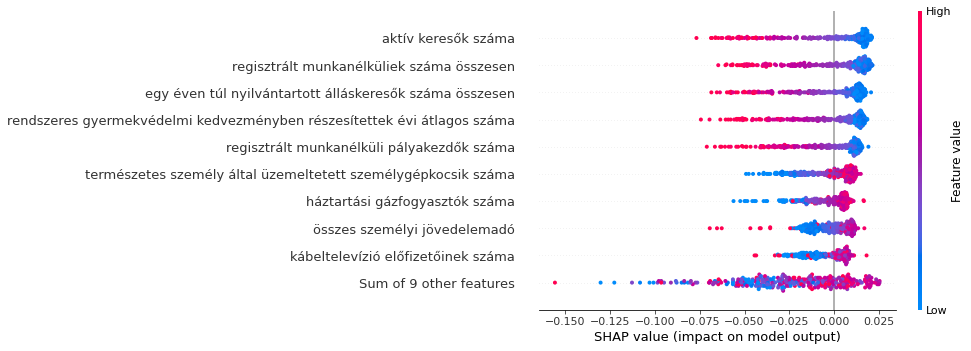

In [ ]:
osztaly = 0
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp)

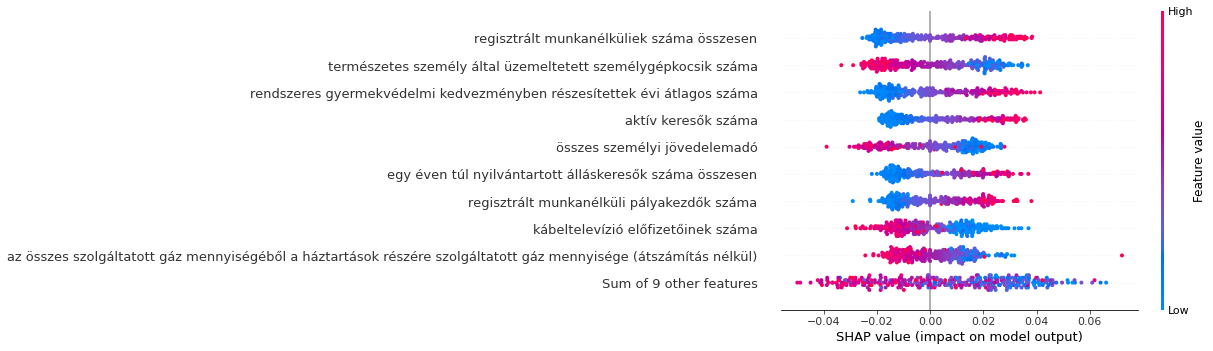

In [ ]:
osztaly = 1
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp)

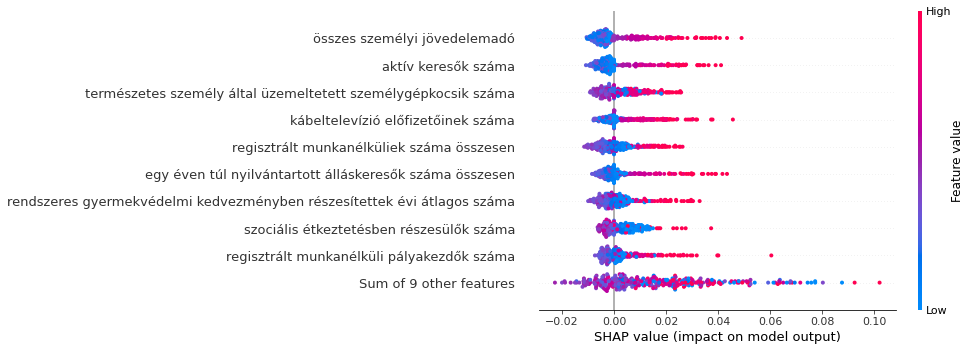

In [ ]:
osztaly = 2
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp)

Not to our surprise we found that one cluster is high unemployment one is low and the other is poor settlements. Although we didn't lose that much information compared to the 5 cluster case (tourist destinations, anomalies), that one is still a more impressive result.

In [ ]:
telepulesek=[]
for i in data_lak_clus.index.values.tolist():
  telepulesek.append(i[0])
telepulesek[:5]

['Aba', 'Abaliget', 'Abasár', 'Abaújalpár', 'Abaújkér']

In [ ]:
X = data_lak_clus_full_scaled.iloc[:, :18]
X['klaszter'] = lak_pca['klaszter']
X['name'] = telepulesek
X.head()

label  a háztartások részére szolgáltatott villamosenergia mennyisége  \
0                                              -0.557013                
1                                               0.791423                
2                                               0.993727                
3                                              -1.131790                
4                                              -0.778544                

label  aktív keresők száma  \
0                -0.671977   
1                -0.361889   
2                -0.571586   
3                 3.976572   
4                -0.252784   

label  az összes szolgáltatott gáz mennyiségéből a háztartások részére szolgáltatott gáz mennyisége (átszámítás nélkül)  \
0                                               0.534615                                                                  
1                                              -1.482091                                                                  
2                                               0.844407                                                                  
3                                              -0.437236                                                                  
4                                              -0.365816                                                                  

label  egy éven túl nyilvántartott álláskeresők száma összesen  \
0                                              -0.728267         
1                                              -0.483076         
2                                              -0.341616         
3                                               2.255306         
4                                               0.140931         

label  elvándorlások száma  háztartási gázfogyasztók száma  \
0                -0.517836                        0.075687   
1                -0.041495                       -1.862985   
2                -0.353005                        0.714537   
3                 0.723757                        0.007873   
4                -0.205110                       -0.602137   

label  háztartási villamosenergia fogyasztók száma  \
0                                        -0.573154   
1                                         0.662283   
2                                        -0.182442   
3                                         0.779072   
4                                        -0.448961   

label  háztartásoknak szolgáltatott víz mennyisége  \
0                                        -0.117560   
1                                         0.656828   
2                                         0.498072   
3                                        -1.501669   
4                                        -0.952785   

label  időskorúak járadékára felhasznált összeg  \
0                                     -0.219405   
1                                     -0.464262   
2                                     -0.288474   
3                                     -0.464262   
4                                     -0.464262   

label  kábeltelevízió előfizetőinek száma  \
0                                0.074772   
1                               -0.947873   
2                                0.435648   
3                               -1.124073   
4                               -0.453012   

label  regisztrált munkanélküli pályakezdők száma  \
0                                       -0.354494   
1                                        0.270038   
2                                       -0.457373   
3                                       -1.091888   
4                                        0.809988   

label  regisztrált munkanélküliek száma összesen  \
0                                      -0.643333   
1                                       0.138945   
2                                      -0.560595   
3                                       2.924066   
4                                       0.418555   

label  rend

In [ ]:
X[X['klaszter']==2]

label  a háztartások részére szolgáltatott villamosenergia mennyisége  \
0                                              -0.557013                
1                                               0.791423                
4                                              -0.778544                
5                                              -2.042480                
7                                              -0.057419                
...                                                  ...                
3131                                           -0.522709                
3133                                            0.488555                
3146                                            0.115695                
3149                                           -0.209615                
3151                                           -0.319607                

label  aktív keresők száma  \
0                -0.671977   
1                -0.361889   
4                -0.252784   
5                -0.116290   
7                 0.695852   
...                    ...   
3131             -0.282324   
3133              0.195401   
3146              0.092174   
3149              0.422448   
3151             -0.364730   

label  az összes szolgáltatott gáz mennyiségéből a háztartások részére szolgáltatott gáz mennyisége (átszámítás nélkül)  \
0                                               0.534615                                                                  
1                                              -1.482091                                                                  
4                                              -0.365816                                                                  
5                                              -1.482091                                                                  
7                                              -0.012696                                                                  
...                                                  ...                                                                  
3131                                            0.773788                                                                  
3133                                           -0.023475                                                                  
3146                                            0.304784                                                                  
3149                                           -0.953624                                                                  
3151                                            0.771600                                                                  

label  egy éven túl nyilvántartott álláskeresők száma összesen  \
0                                              -0.728267         
1                                              -0.483076         
4                                               0.140931         
5                                              -0.517520         
7                                               0.478931         
...                                                  ...         
3131                                           -0.351080         
3133                                           -0.077680         
3146                                            0.249602         
3149                                            1.395930         
3151                                           -0.207600         

label  elvándorlások száma  háztartási gázfogyasztók száma  \
0                -0.517836                        0.075687   
1                -0.041495                       -1.862985   
4                -0.205110                       -0.602137   
5                 0.475815                       -1.862985   
7                -0.430669                       -0.446559   
...                    ...                             ...   
3131             -0.293054                        0.692554

In [ ]:
X_geo = X.merge(geoname, on='name')
X_geo.head()

a háztartások részére szolgáltatott villamosenergia mennyisége  \
0                                          -0.557013                
1                                           0.791423                
2                                           0.993727                
3                                          -1.131790                
4                                          -0.778544                

   aktív keresők száma  \
0            -0.671977   
1            -0.361889   
2            -0.571586   
3             3.976572   
4            -0.252784   

   az összes szolgáltatott gáz mennyiségéből a háztartások részére szolgáltatott gáz mennyisége (átszámítás nélkül)  \
0                                           0.534615                                                                  
1                                          -1.482091                                                                  
2                                           0.844407                                                                  
3                                          -0.437236                                                                  
4                                          -0.365816                                                                  

   egy éven túl nyilvántartott álláskeresők száma összesen  \
0                                          -0.728267         
1                                          -0.483076         
2                                          -0.341616         
3                                           2.255306         
4                                           0.140931         

   elvándorlások száma  háztartási gázfogyasztók száma  \
0            -0.517836                        0.075687   
1            -0.041495                       -1.862985   
2            -0.353005                        0.714537   
3             0.723757                        0.007873   
4            -0.205110                       -0.602137   

   háztartási villamosenergia fogyasztók száma  \
0                                    -0.573154   
1                                     0.662283   
2                                    -0.182442   
3                                     0.779072   
4                                    -0.448961   

   háztartásoknak szolgáltatott víz mennyisége  \
0                                    -0.117560   
1                                     0.656828   
2                                     0.498072   
3                                    -1.501669   
4                                    -0.952785   

   időskorúak járadékára felhasznált összeg  \
0                                 -0.219405   
1                                 -0.464262   
2                                 -0.288474   
3                                 -0.464262   
4                                 -0.464262   

   kábeltelevízió előfizetőinek száma  ...  \
0                            0.074772  ...   
1                           -0.947873  ...   
2                            0.435648  ...   
3                           -1.124073  ...   
4                           -0.453012  ...   

   szociális étkeztetésben részesülők száma  \
0                                 -0.783704   
1                                 -0.638031   
2                                 -0.451231   
3                                 -0.840673   
4                                  1.451481   

   természetes személy által üzemeltetett személygépkocsik száma  \
0                                          -0.603504               
1                                           0.819765               
2                                           1.544141               
3                                          -0.569080               
4                                          -1.585936               

   összes személyi jövedelemadó  üzemelő közkifolyók száma  klaszter  \
0                      0.112319                  -0.414850         2

In [ ]:
file_old = '/content/drive/My Drive/Temalabor1/momap.geojson'
file_new = '/content/drive/My Drive/Diplomamunka/klaszter3_2010_lak.geojson'

import json
with open(file_old, 'r') as f:
    data = json.load(f)

for feature in data['features']:
    geoid2 = feature['properties']['geoid']
    if len(X_geo[X_geo['geoid'] == geoid2]['klaszter']) == 0:
      del feature
    else:
      feature['properties']['klaszter'] = X_geo[X_geo.geoid == geoid2]['klaszter'].item()
      feature['properties']['varos'] = str(X_geo[X_geo.geoid == geoid2]['name'].item())

with open(file_new, 'w+') as f:
    json.dump(data, f, indent=2)

# Repeating the analysis with the red wine dataset

Also we wondered how does this method translate to a completely different, smaller dataset. Due to the size, the final figures don't really show a strong picture no matter the percentage or the cluster number, but the rest of the steps work alright.

In [ ]:
from sklearn.datasets import load_wine
data = load_wine()
y = load_wine(return_X_y=True)[1]
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = y
df.head()

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  target  
0                          3.92   1065.0       0  
1                          3.40   1050.0       0  
2                          3.17   1185.0       0  
3                          3.45   1480.0       0  
4                          2.93    735.0       0

In [ ]:
scaler = StandardScaler()
df = df.iloc[:, :-1]
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled.head()

alcohol  malic_acid       ash  alcalinity_of_ash  magnesium  \
0  1.518613   -0.562250  0.232053          -1.169593   1.913905   
1  0.246290   -0.499413 -0.827996          -2.490847   0.018145   
2  0.196879    0.021231  1.109334          -0.268738   0.088358   
3  1.691550   -0.346811  0.487926          -0.809251   0.930918   
4  0.295700    0.227694  1.840403           0.451946   1.281985   

   total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
0       0.808997    1.034819             -0.659563         1.224884   
1       0.568648    0.733629             -0.820719        -0.544721   
2       0.808997    1.215533             -0.498407         2.135968   
3       2.491446    1.466525             -0.981875         1.032155   
4       0.808997    0.663351              0.226796         0.401404   

   color_intensity       hue  od280/od315_of_diluted_wines   proline  
0         0.251717  0.362177                      1.847920  1.013009  
1        -0.293321  0.406051                      1.113449  0.965242  
2         0.269020  0.318304                      0.788587  1.395148  
3         1.186068 -0.427544                      1.184071  2.334574  
4        -0.319276  0.362177                      0.449601 -0.037874

In [ ]:
X = df_scaled.values

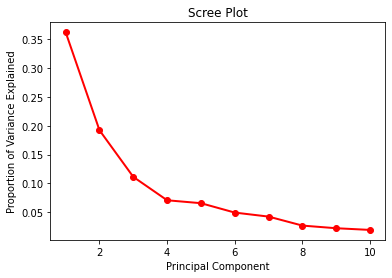

In [ ]:
pca = PCA(n_components=10)
principalComponents=pca.fit_transform(X)

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [ ]:
out_sum = np.cumsum(pca.explained_variance_ratio_)  
print ("Cumulative Prop. Variance Explained: ", out_sum)

Cumulative Prop. Variance Explained:  [0.36198848 0.55406338 0.66529969 0.73598999 0.80162293 0.85098116
 0.89336795 0.92017544 0.94239698 0.96169717]


## 6 PCS

In [ ]:
X = df_scaled.values

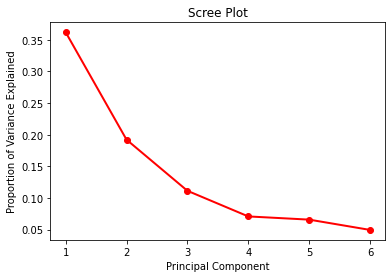

In [ ]:
pca = PCA(n_components=6)
principalComponents=pca.fit_transform(X)

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [ ]:
bor_pca = pd.DataFrame(data = principalComponents, 
                  columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
bor_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6
0  3.316751 -1.443463 -0.165739 -0.215631  0.693043 -0.223880
1  2.209465  0.333393 -2.026457 -0.291358 -0.257655 -0.927120
2  2.516740 -1.031151  0.982819  0.724902 -0.251033  0.549276
3  3.757066 -2.756372 -0.176192  0.567983 -0.311842  0.114431
4  1.008908 -0.869831  2.026688 -0.409766  0.298458 -0.406520

For n_clusters = 2 The average silhouette_score is : 0.26831340971052126
For n_clusters = 3 The average silhouette_score is : 0.2848589191898987
For n_clusters = 4 The average silhouette_score is : 0.24519129323772165
For n_clusters = 5 The average silhouette_score is : 0.23223087806001866
For n_clusters = 6 The average silhouette_score is : 0.23533337693317755


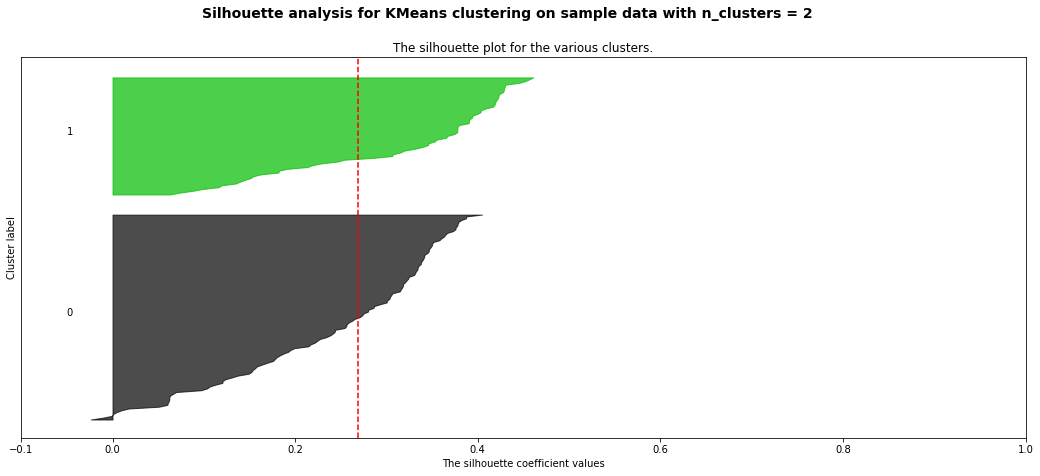

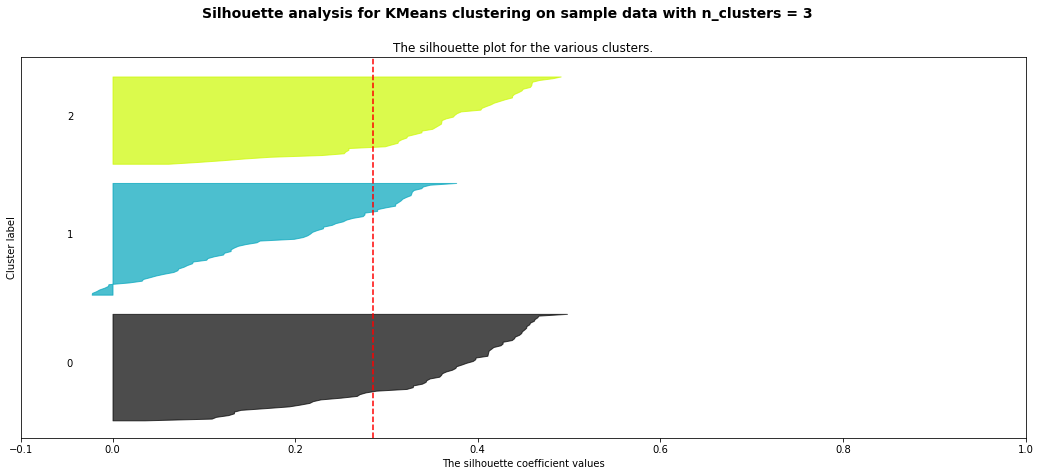

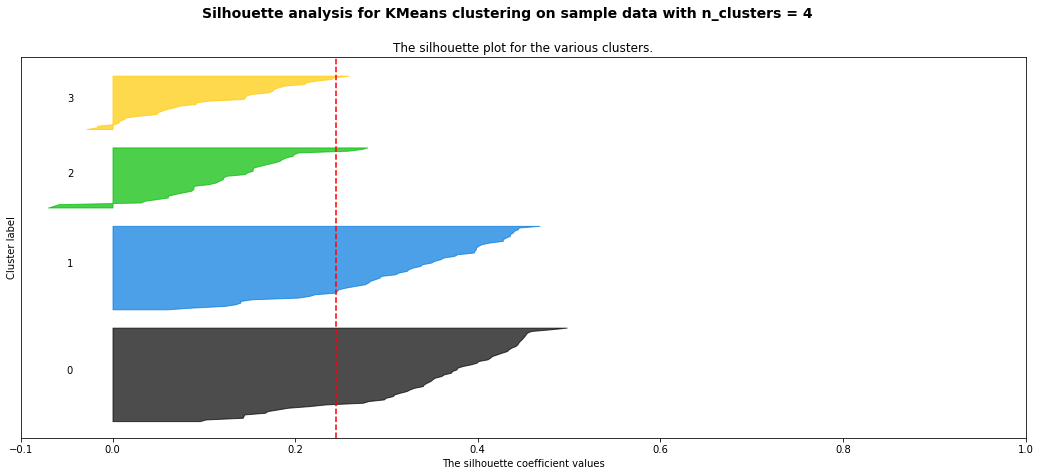

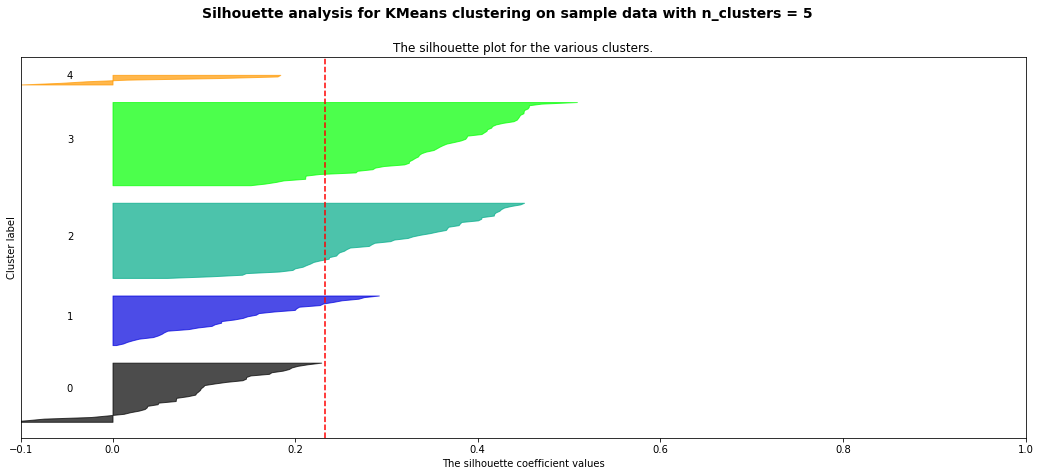

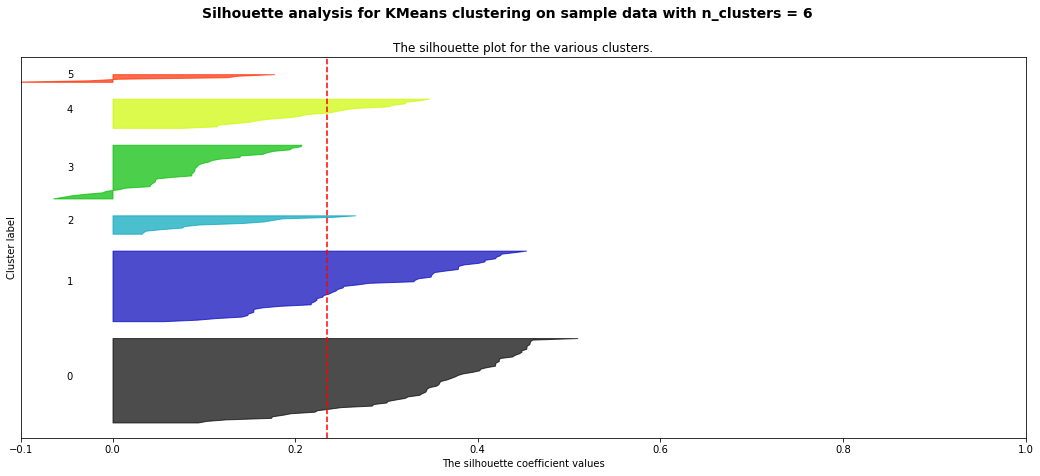

In [ ]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### K=3

In [ ]:
K=3


KMC=KMeans(n_clusters=K)
KMC.fit(bor_pca)
bor_pca['klaszter']=KMC.labels_

In [ ]:
X = df_scaled.to_numpy()
y = bor_pca['klaszter']

In [ ]:
clusterShapley = dre.ClusterShapley()
clusterShapley.fit(X, y)

to_explain = np.array(random.sample(X.tolist(), int(X.shape[0] * 0.1)))

shap_values = clusterShapley.transform(to_explain)

Preprocessing data...
Creating summary of the background dataset...
Computing explanations...


  0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
features = list(df_scaled.columns)

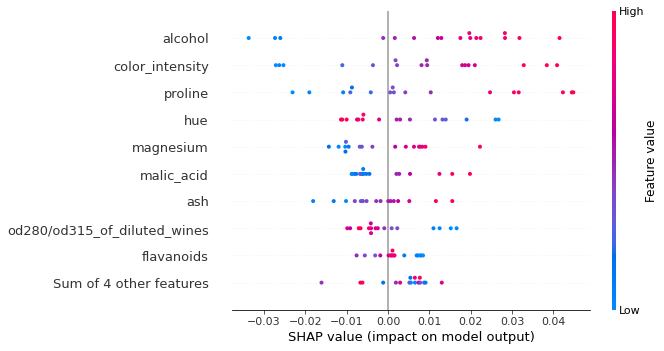

In [ ]:
osztaly = 0
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp)

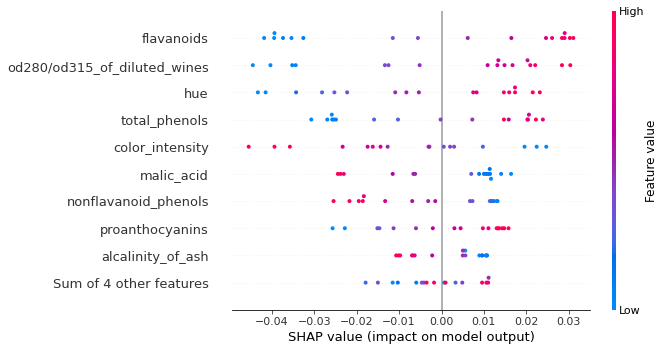

In [ ]:
osztaly = 1
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp)

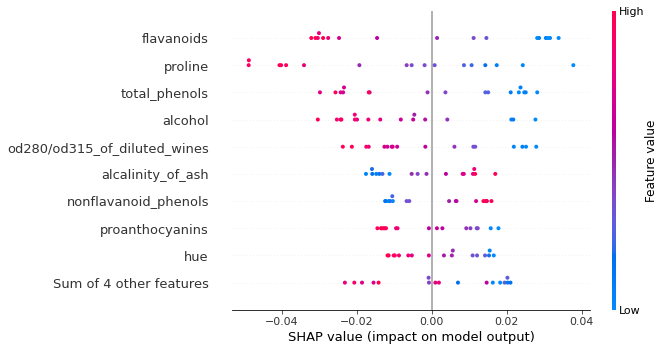

In [ ]:
osztaly = 2
c_exp = shap.Explanation(shap_values[osztaly], data=to_explain, feature_names=features)
shap.plots.beeswarm(c_exp)